# Astronomical Data Processing

### Léo BECHET - M2 CompuPhys - 2024-2025

In [15]:
import numpy as np
from astropy.io import fits
from scipy.signal import correlate2d
import matplotlib.pyplot as plt


In [16]:
def instrumental_mag(F_obj: float , t_exp: float):
    return -2.5 * np.log(F_obj/t_exp)

## Reference star used

We use the following star as a reference

![ref star](./rsc/ref_star_9.png)

1881599.6012235654


/tmp/ipykernel_432921/2393849239.py:82: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Magnitude=-2.5*log10(Sum_target)
/tmp/ipykernel_432921/2393849239.py:86: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Sky_magnitude = -2.5 * log10(Sky_flux)


{'mjd': 52191.0812616,
 'exptime': 180.0,
 'magnitude': -16.692119624385025,
 'sky': -9.181168052564944}

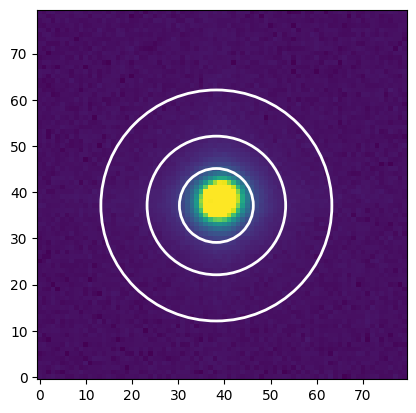

In [17]:


# Adaptation of what's going in in the given file idk....

#  File M2_CompuPhys_Data_Processing.py for Astronomical data processing course
#
#  Example of Python code for measuring magnitudes in a fits image... Needs to be adapted !

filename = "data/9_Oct/td10r_n3_0066.fits"


r=8         # radius for measuring target flux
r_in=15     # inner radius for the annulus used for measuring sky background
r_out=25    # outer radius for the annulus used for measuring sky background 


Xcent=1685     # approximate target coordinates (x)
Ycent=1091      # approximate target coordinates (y)


def GivenFileThingy(filename, r, r_in, r_out, Xcent, Ycent, side,debug=False):

    hdulist = fits.open(filename)       # Define the image name to open
    if debug: hdulist.info()                                  # To get information on the image

    header = hdulist[0].header

    scidata = hdulist[0].data                 # transfer the image (pixels values) in scidata
    if debug: print("data shape : ", scidata.shape)
    mjd = header['MJD-OBS']
    if debug: print("mjd : ", mjd)
    exptime = header['EXPTIME']
    if debug: print("exposition : ", exptime," secs")

    #print(repr(header))                # to print all the descriptors in the header, if necessary
    #print(repr(header['MJD-OBS']))     # to print a given descriptor, if necessary
    #scidata /= exptime                # divide the image by its exposure time, if necessary


    from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
    from astropy.visualization import simple_norm



    from photutils.centroids import centroid_com, centroid_1dg, centroid_2dg, centroid_quadratic
    data = scidata[Ycent-side:Ycent+side,Xcent-side:Xcent+side]  # subimage centered on the target

    x1, y1 = centroid_quadratic(data)     # for computing accurately the position of maximum of brightness
    if debug: print('resultats centroid =%.3f'%(x1),',%.3f'%(y1))


    norm = simple_norm(data, 'sqrt', percent=99)
    plt.imshow(data, norm=norm, origin='lower')
    positions = [(x1, y1)]
    aperture = CircularAperture(positions, r)
    annulus_aperture = CircularAnnulus(positions, r_in, r_out)

    aperture.plot(color='white', lw=2)
    annulus_aperture.plot(color='white', lw=2)


    phot_table = aperture_photometry(data, aperture)
    phot_table['aperture_sum'].info.format = '%.8g'  # for consistent table output
    if debug: print(phot_table)
    Sum_target_raw=(phot_table['aperture_sum'])

    if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))

    phot_table = aperture_photometry(data, annulus_aperture)
    phot_table['aperture_sum'].info.format = '%.8g'  # for consistent table output
    if debug: print(phot_table)
    Sky_background=(phot_table['aperture_sum'])

    if debug: print('\nSky_background=%.3f\n'%(Sky_background))






    from math import log10
    Sum_target=Sum_target_raw-Sky_background/(r_out*r_out-r_in*r_in)*(r*r)
    if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
    Magnitude=-2.5*log10(Sum_target)
    if debug: print('instrumental magnitude=%.3f\n'%(Magnitude))

    Sky_flux = Sky_background / (r_out * r_out - r_in * r_in)  # Sky flux density per pixel
    Sky_magnitude = -2.5 * log10(Sky_flux)

    print(Sky_background[0])

    hdulist.close()

    if debug: plt.show()

    return {
        "mjd": mjd,
        "exptime": exptime,
        "magnitude": Magnitude,
        "sky": Sky_magnitude
    }


GivenFileThingy(filename, r, r_in, r_out, Xcent, Ycent, 40)


# Frame Alignment

 

In [18]:
import numpy as np
from astropy.io import fits
from scipy.signal import correlate2d
import matplotlib.pyplot as plt

def CreateOffsetArray(files, ref_star, bounding_size, Debug=False, Verbose=False):
    """
    Compute the pixel offsets between images based on the reference star's position, with optional debugging plots.
    
    Parameters:
    - files: list of strings, paths to FITS files.
    - ref_star: tuple (Xcent, Ycent), initial coordinates of the reference star in the first image.
    - bounding_size: integer, size of the bounding box (half-width) around the reference star.
    - Debug: boolean, if True, plots the bounding box and star position for each image.
    
    Returns:
    - offsets: list of tuples, containing pixel offsets (dx, dy) for each image relative to the first.
    """
    
    # Initialize an empty list to store offsets
    offsets = []
    
    # Open the first image and extract the reference subimage
    hdulist = fits.open(files[0])
    scidata = hdulist[0].data
    Xcent, Ycent = ref_star
    ref_subimage = scidata[Ycent-bounding_size:Ycent+bounding_size, Xcent-bounding_size:Xcent+bounding_size]
    
    # Initialize the first image's offset as (0, 0)
    offsets.append((0, 0))
    
    if Debug:
        plt.figure(figsize=(10, 5))
    
    # Iterate over the rest of the images
    for i in range(1, len(files)):
        if Verbose: print(f' Aligning image {i}/{len(files)}')
        # Open the current image
        hdulist = fits.open(files[i])
        scidata = hdulist[0].data
        
        # Extract the subimage around the current reference star position
        curr_subimage = scidata[Ycent-bounding_size:Ycent+bounding_size, Xcent-bounding_size:Xcent+bounding_size]
        
        # Perform cross-correlation to find the shift
        correlation = correlate2d(curr_subimage, ref_subimage, mode='same')
        max_loc = np.unravel_index(np.argmax(correlation), correlation.shape)
        offset_y = max_loc[0] - correlation.shape[0] // 2
        offset_x = max_loc[1] - correlation.shape[1] // 2
        
        # Update the reference star's position for the next image
        Xcent += offset_x
        Ycent += offset_y
        
        # Add the computed offset to the list
        offsets.append((offset_x, offset_y))
        if Verbose: print(f'    Offset : {(offset_x, offset_y)}')
        
        # Debug plotting
        if Debug:
            fig, ax = plt.subplots(1, 2, figsize=(12, 6))
            
            # Show the full image with bounding box
            ax[0].imshow(scidata, cmap='gray', origin='lower')
            rect = plt.Rectangle((Xcent-bounding_size, Ycent-bounding_size), 2*bounding_size, 2*bounding_size,
                                 linewidth=1, edgecolor='r', facecolor='none')
            ax[0].add_patch(rect)
            ax[0].scatter(Xcent, Ycent, color='blue', label='New Star Position')
            ax[0].set_title(f"Image {i + 1}: Full Image with Bounding Box")
            ax[0].legend()
            
            # Show the subimage for clarity
            ax[1].imshow(curr_subimage, cmap='gray', origin='lower')
            ax[1].set_title(f"Image {i + 1}: Subimage Around Star")
            
            plt.show()
    
    return offsets


In [19]:
def compute_absolute_offsets(relative_offsets):
    """
    Compute the absolute offsets from a list of relative offsets.
    
    Parameters:
    - relative_offsets: list of tuples, each containing the relative offset (dx, dy) from the previous frame.
    
    Returns:
    - absolute_offsets: list of tuples, each containing the absolute offset (dx, dy) from the first frame.
    """
    
    # Initialize the absolute offsets list
    absolute_offsets = []
    
    # Initialize the cumulative offset (start with 0, 0 for the first frame)
    cumulative_offset_x = 0
    cumulative_offset_y = 0
    
    # Loop through each relative offset and accumulate to get the absolute offset
    for dx, dy in relative_offsets:
        # Update the cumulative offset
        cumulative_offset_x += dx
        cumulative_offset_y += dy
        
        # Append the new absolute offset to the list
        absolute_offsets.append((cumulative_offset_x, cumulative_offset_y))
    
    return absolute_offsets

['data/9_Oct/td10r_n3_0066.fits', 'data/9_Oct/td10r_n3_0068.fits', 'data/9_Oct/td10r_n3_0070.fits', 'data/9_Oct/td10r_n3_0072.fits', 'data/9_Oct/td10r_n3_0074.fits', 'data/9_Oct/td10r_n3_0076.fits', 'data/9_Oct/td10r_n3_0078.fits', 'data/9_Oct/td10r_n3_0080.fits', 'data/9_Oct/td10r_n3_0082.fits', 'data/9_Oct/td10r_n3_0084.fits', 'data/9_Oct/td10r_n3_0086.fits', 'data/9_Oct/td10r_n3_0088.fits', 'data/9_Oct/td10r_n3_0090.fits', 'data/9_Oct/td10r_n3_0092.fits', 'data/9_Oct/td10r_n3_0094.fits', 'data/9_Oct/td10r_n3_0096.fits', 'data/9_Oct/td10r_n3_0103.fits', 'data/9_Oct/td10r_n3_0105.fits', 'data/9_Oct/td10r_n3_0107.fits', 'data/9_Oct/td10r_n3_0109.fits', 'data/9_Oct/td10r_n3_0117.fits', 'data/9_Oct/td10r_n3_0119.fits', 'data/9_Oct/td10r_n3_0121.fits', 'data/9_Oct/td10r_n3_0123.fits', 'data/9_Oct/td10r_n3_0128.fits', 'data/9_Oct/td10r_n3_0130.fits', 'data/9_Oct/td10r_n3_0134.fits', 'data/9_Oct/td10r_n3_0136.fits', 'data/9_Oct/td10r_n3_0138.fits', 'data/9_Oct/td10r_n3_0143.fits', 'data/9_O

<Figure size 1000x500 with 0 Axes>

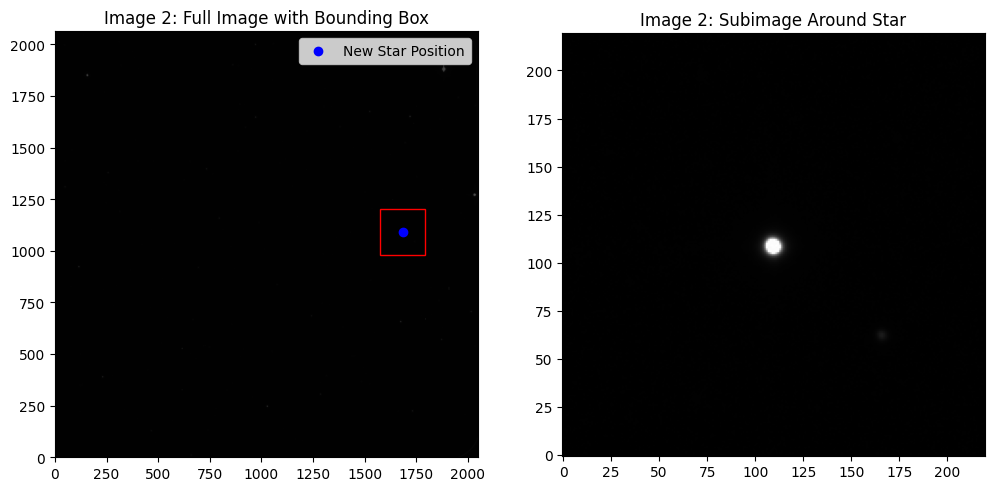

 Aligning image 2/33
    Offset : (-4, 34)


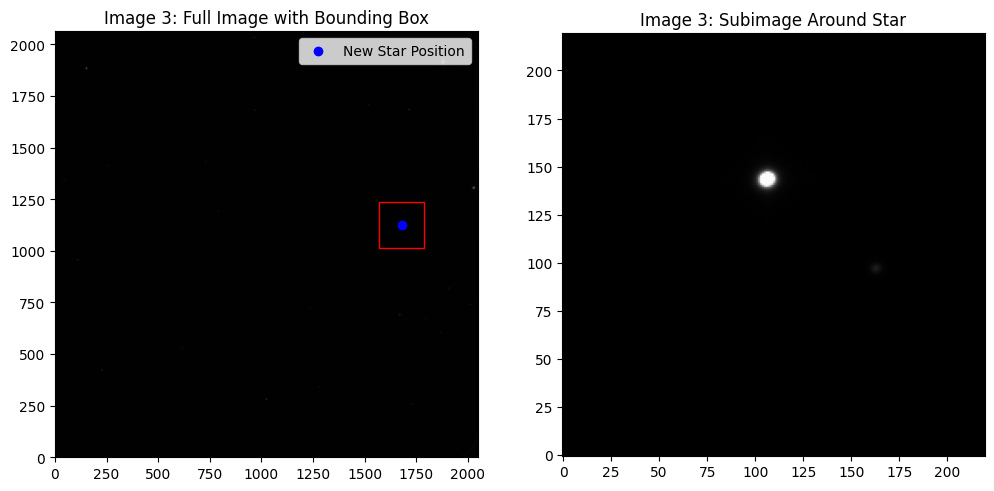

 Aligning image 3/33
    Offset : (0, 1)


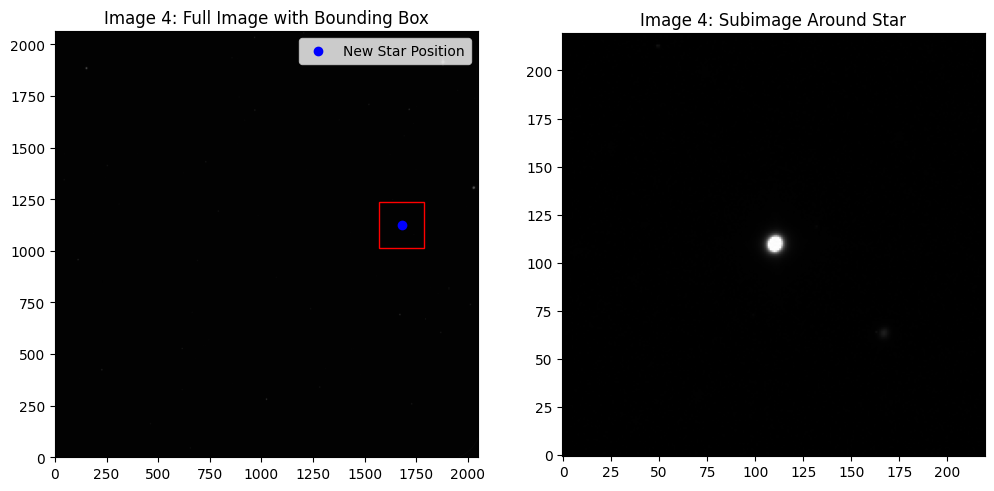

 Aligning image 4/33
    Offset : (0, 0)


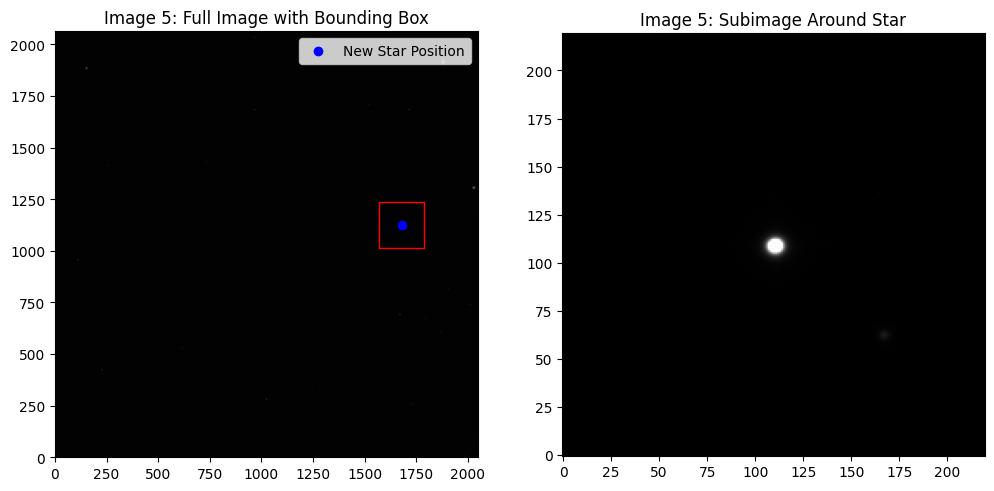

 Aligning image 5/33
    Offset : (1, 0)


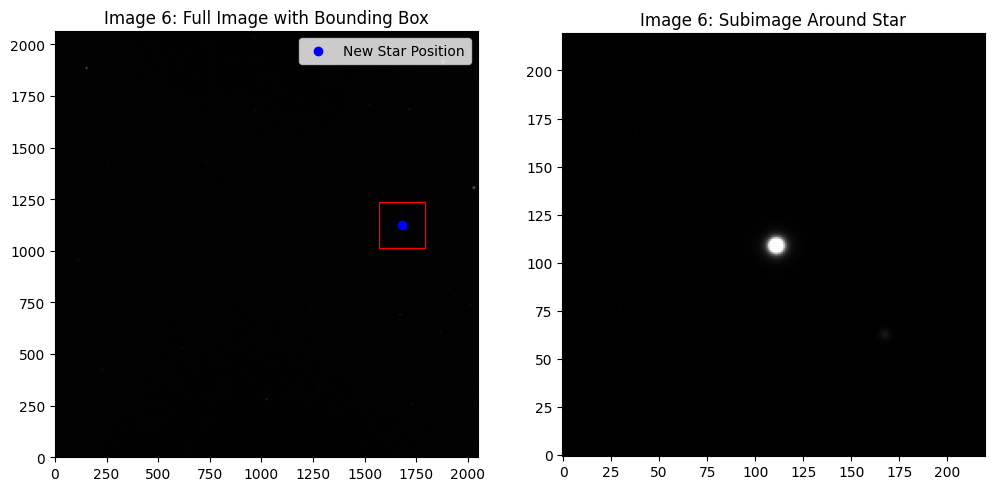

 Aligning image 6/33
    Offset : (0, 0)


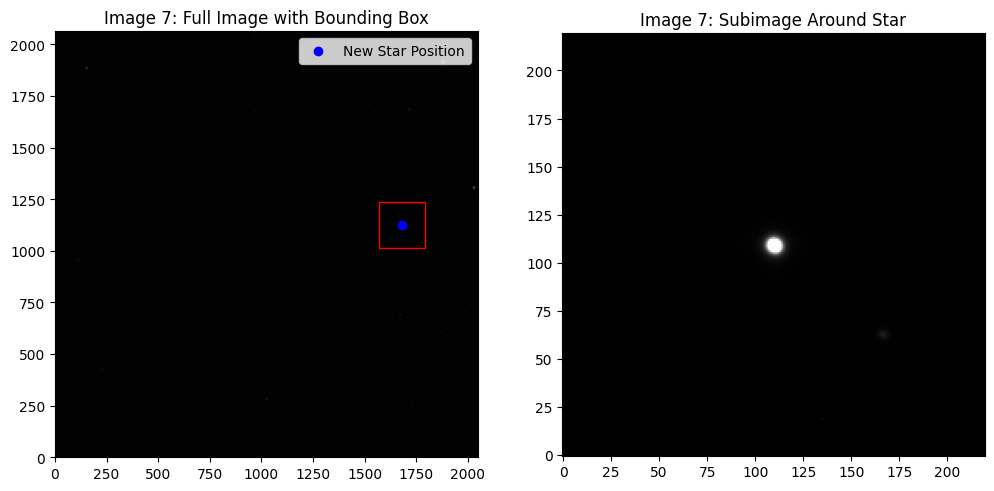

 Aligning image 7/33
    Offset : (0, 0)


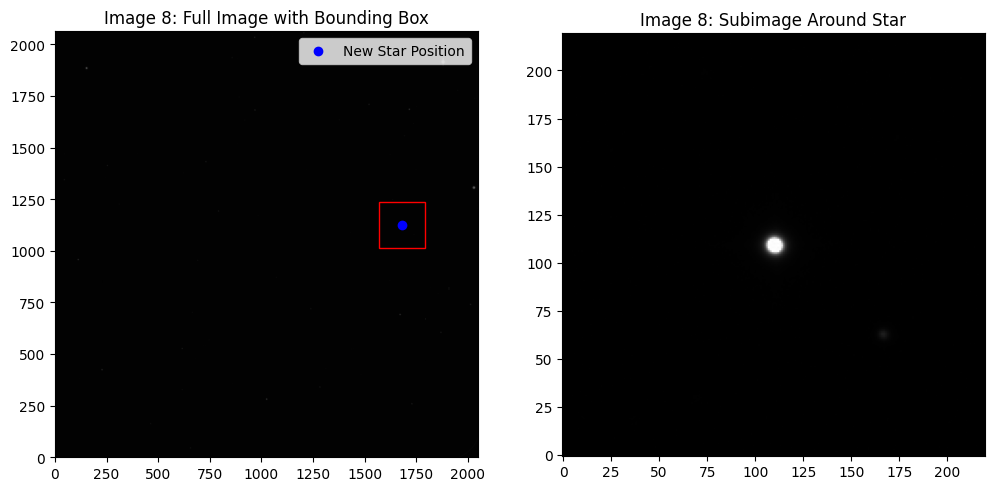

 Aligning image 8/33
    Offset : (0, 0)


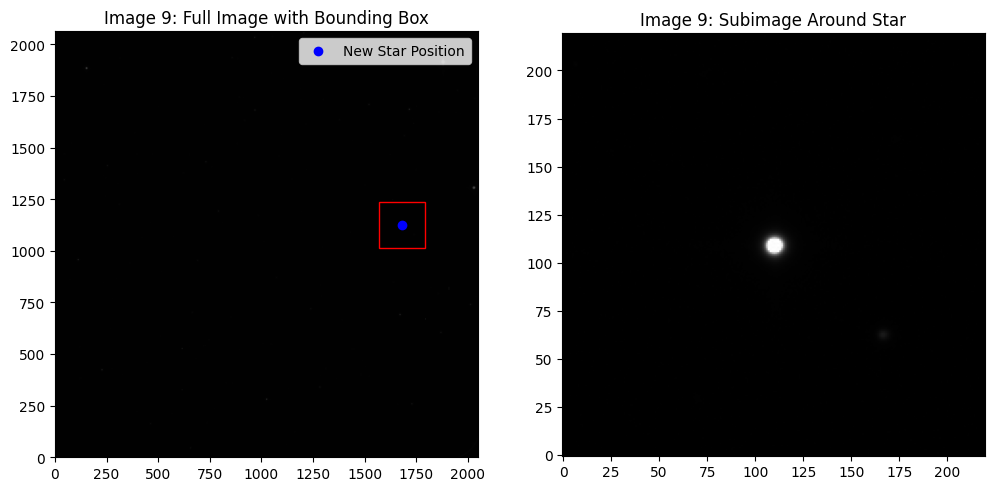

 Aligning image 9/33
    Offset : (0, 0)


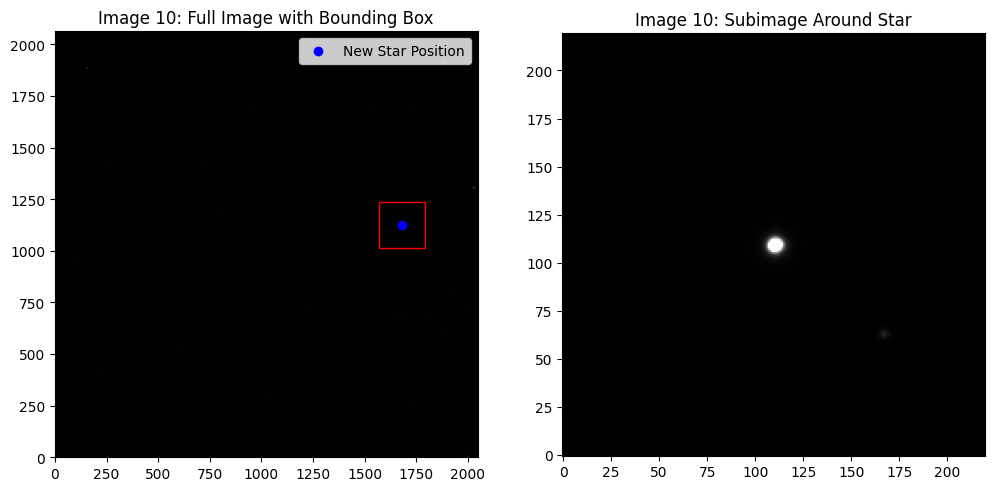

 Aligning image 10/33
    Offset : (1, 0)


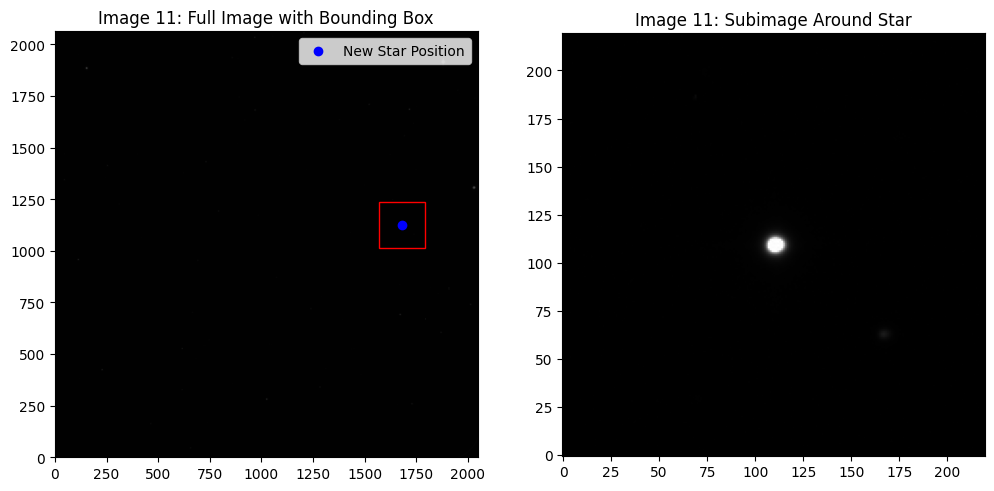

 Aligning image 11/33
    Offset : (0, 0)


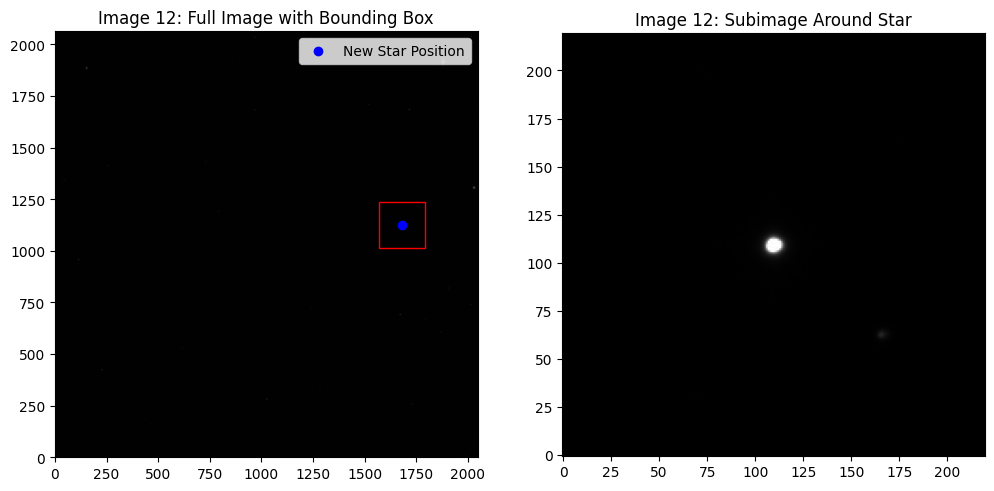

 Aligning image 12/33
    Offset : (-107, -5)


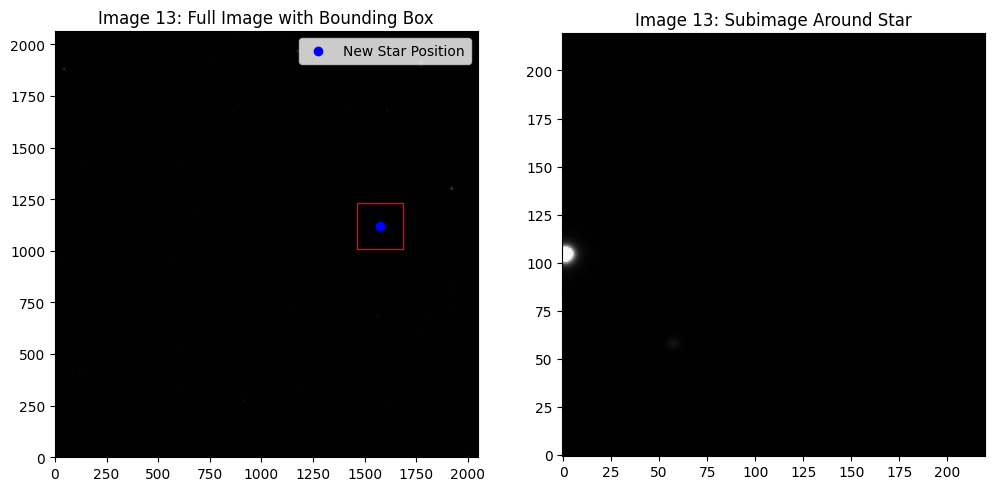

 Aligning image 13/33
    Offset : (-2, 0)


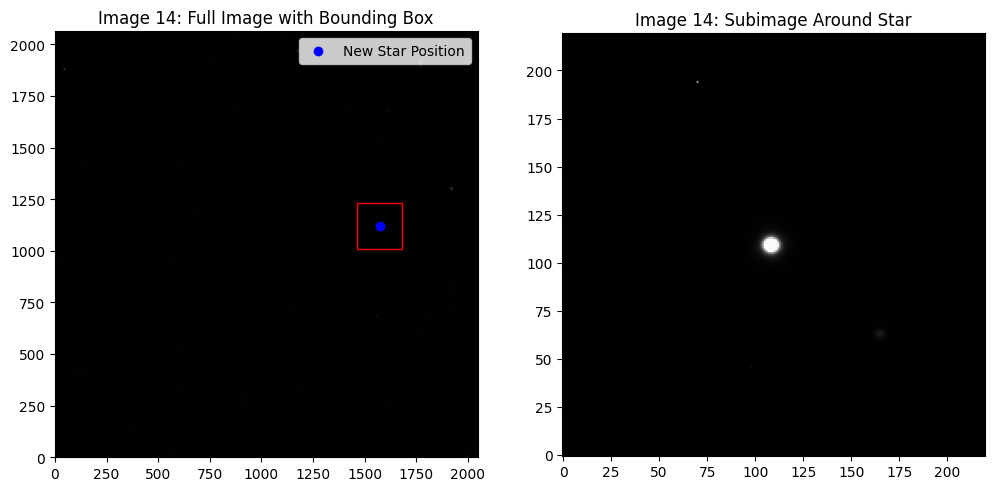

 Aligning image 14/33
    Offset : (-3, -49)


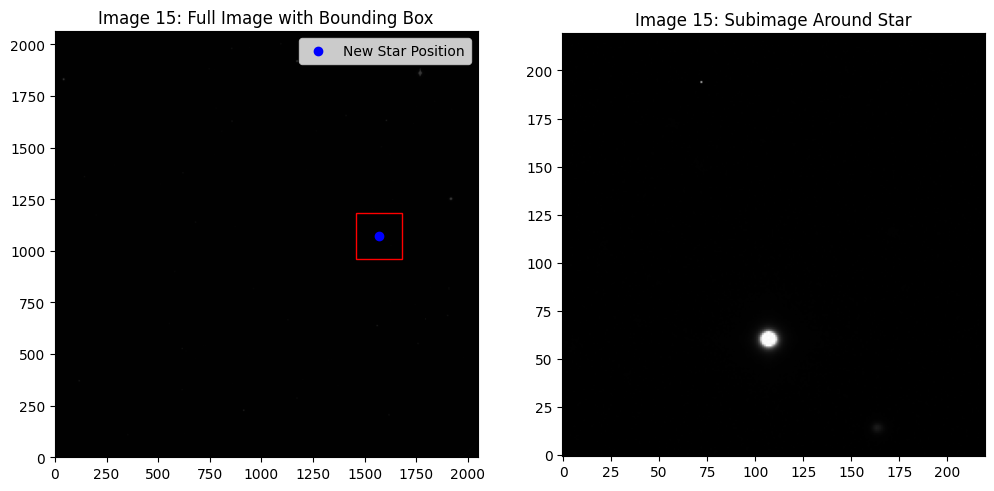

 Aligning image 15/33
    Offset : (0, 0)


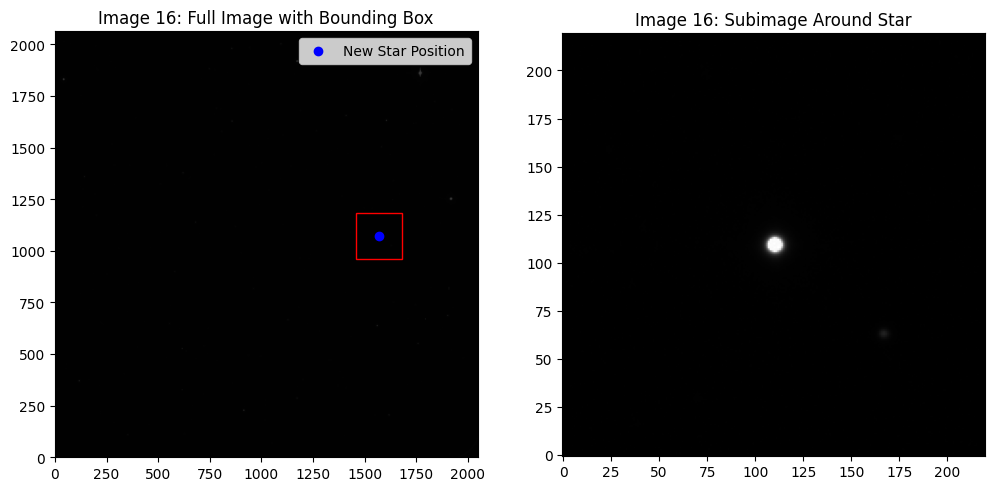

 Aligning image 16/33
    Offset : (43, 27)


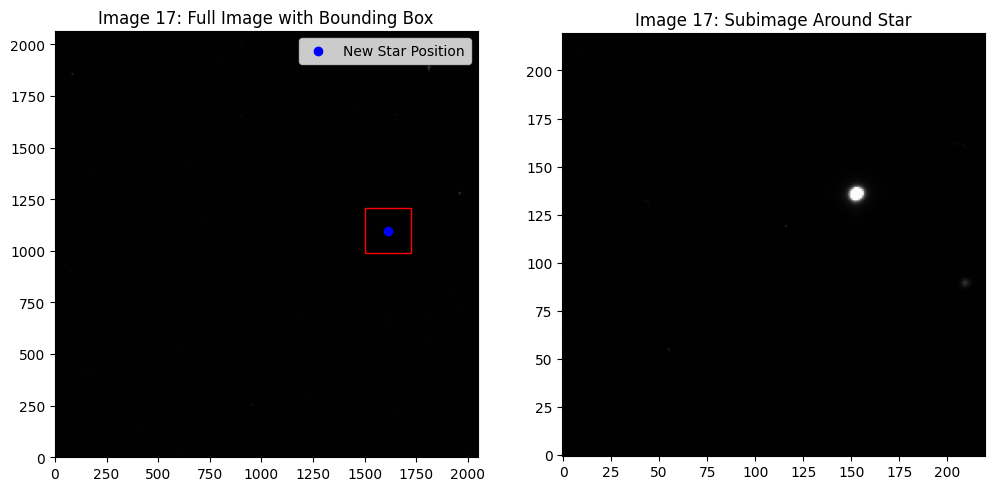

 Aligning image 17/33
    Offset : (0, 0)


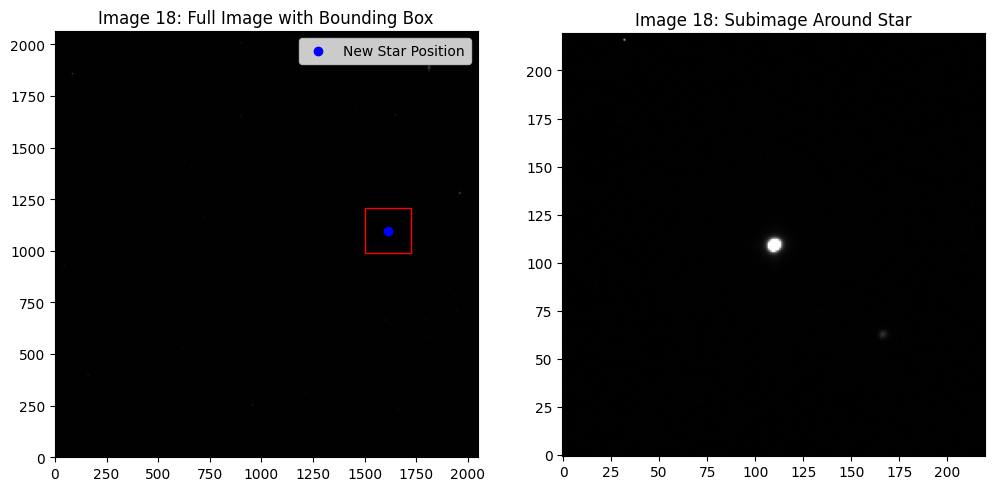

 Aligning image 18/33
    Offset : (4, -24)


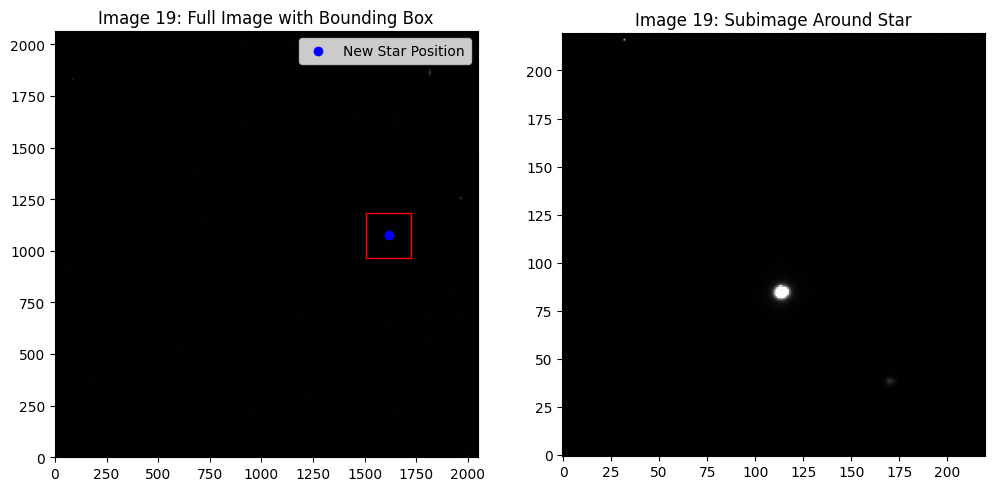

 Aligning image 19/33
    Offset : (0, 0)


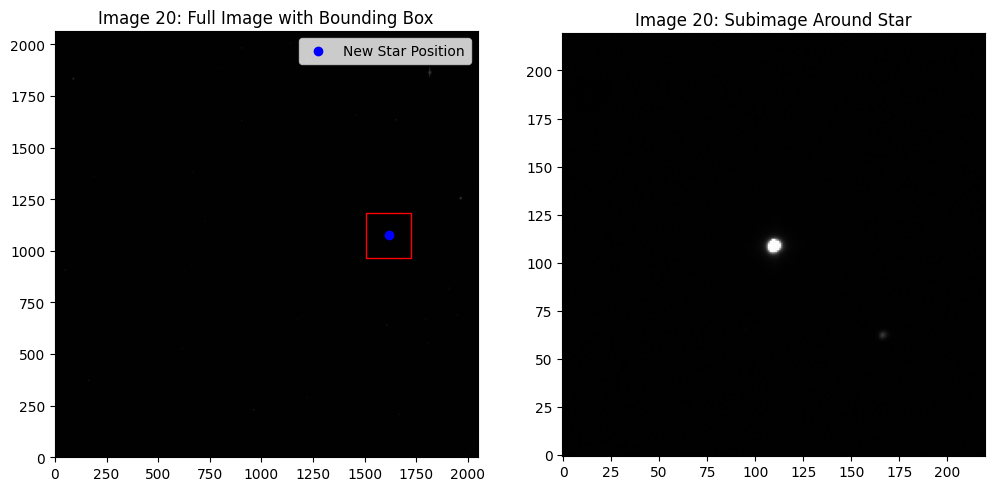

 Aligning image 20/33
    Offset : (83, 31)


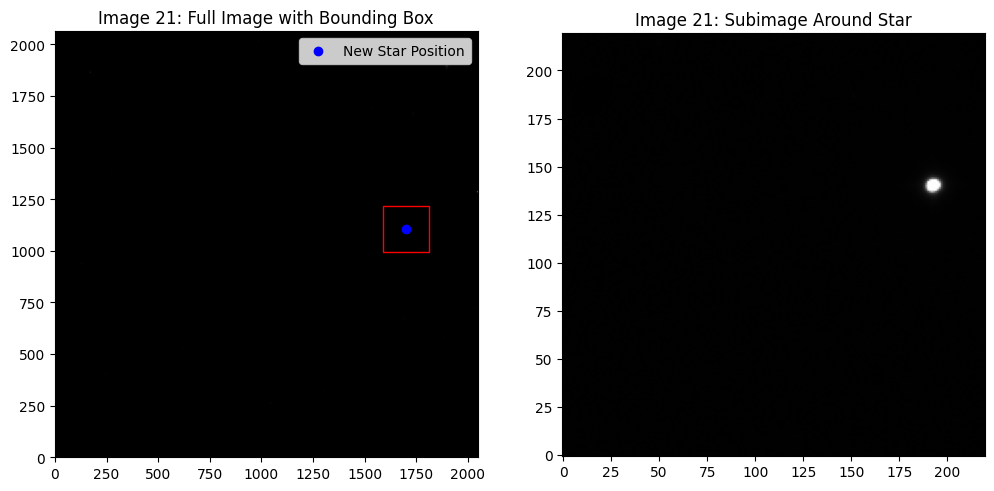

 Aligning image 21/33
    Offset : (0, 0)


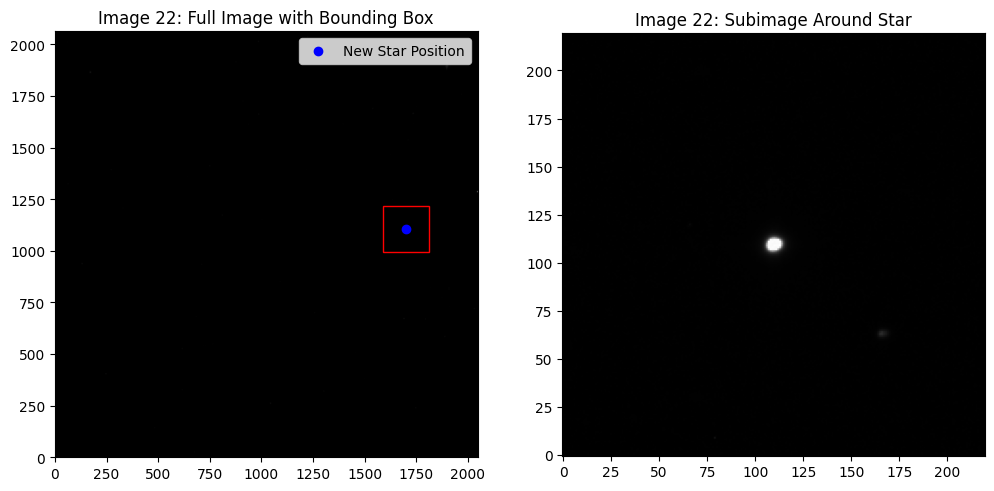

 Aligning image 22/33
    Offset : (0, 1)


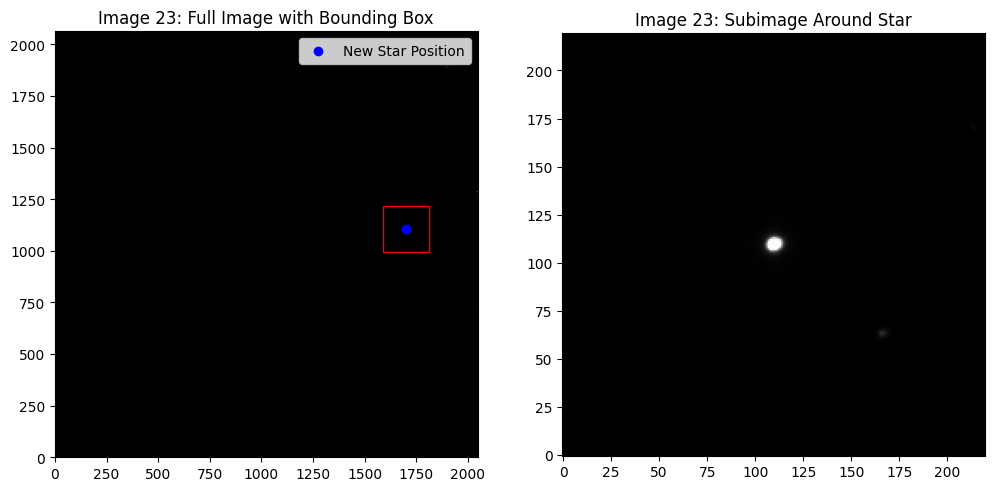

 Aligning image 23/33
    Offset : (0, -1)


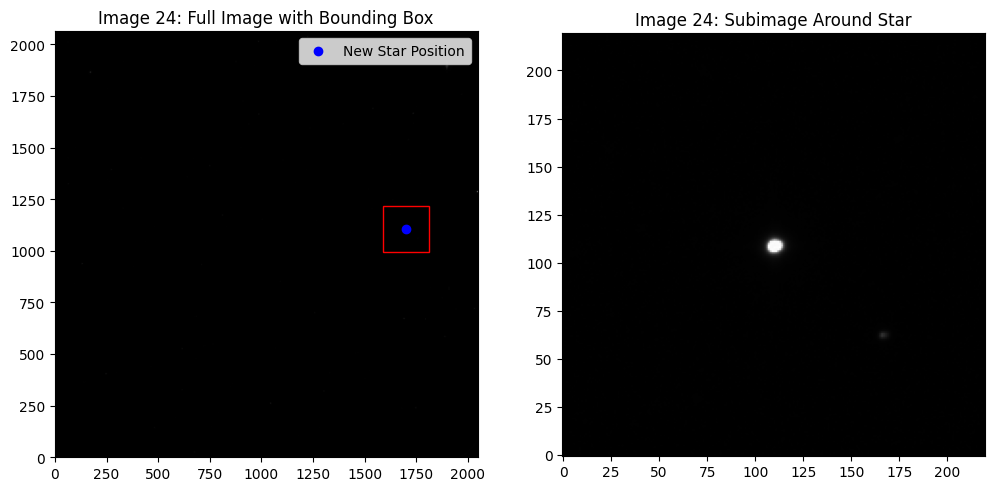

 Aligning image 24/33
    Offset : (-32, -94)


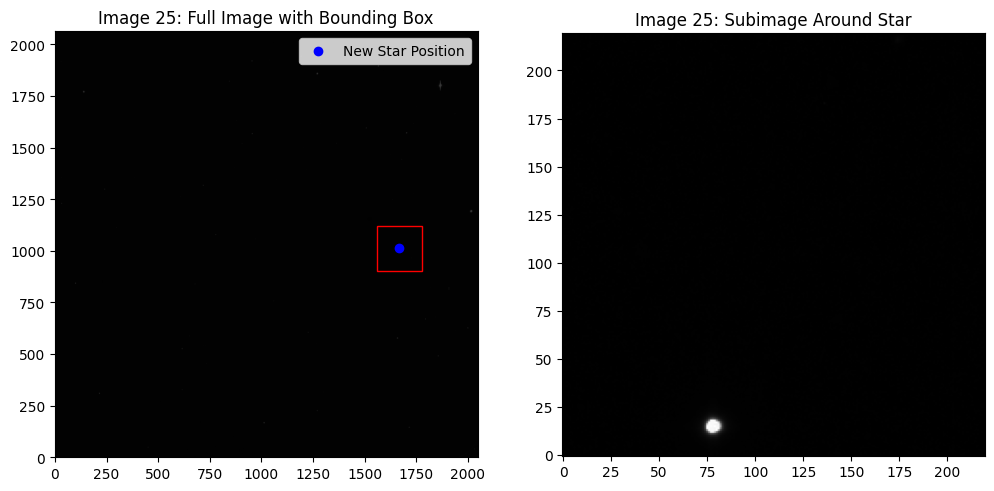

 Aligning image 25/33
    Offset : (0, 0)


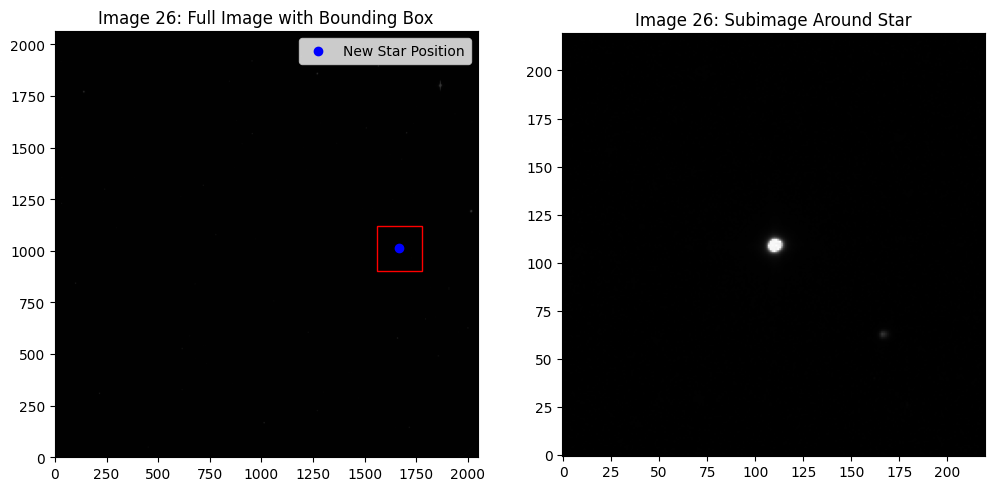

 Aligning image 26/33
    Offset : (1, 0)


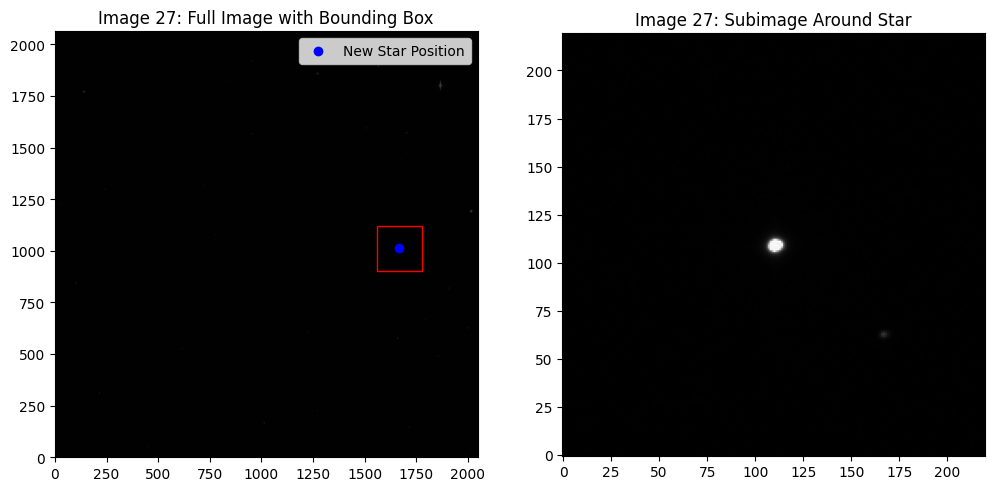

 Aligning image 27/33
    Offset : (-30, -4)


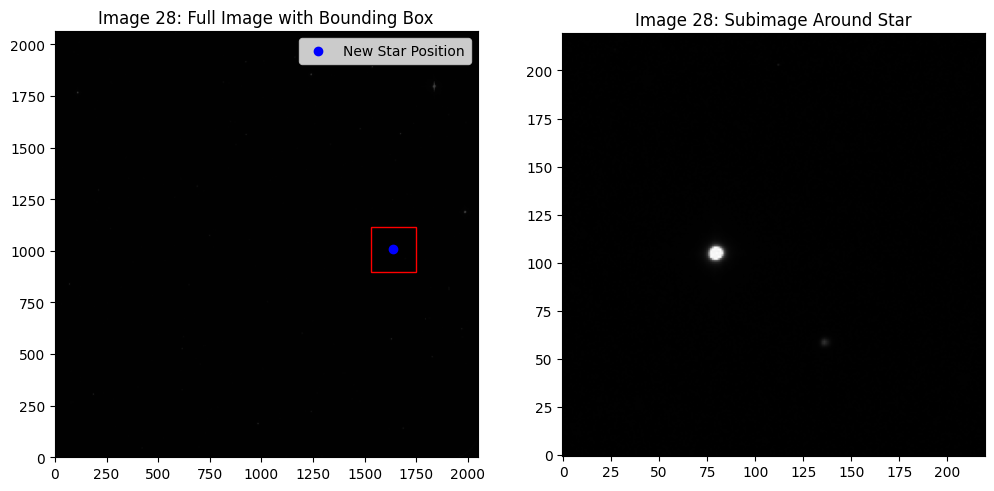

 Aligning image 28/33
    Offset : (0, 0)


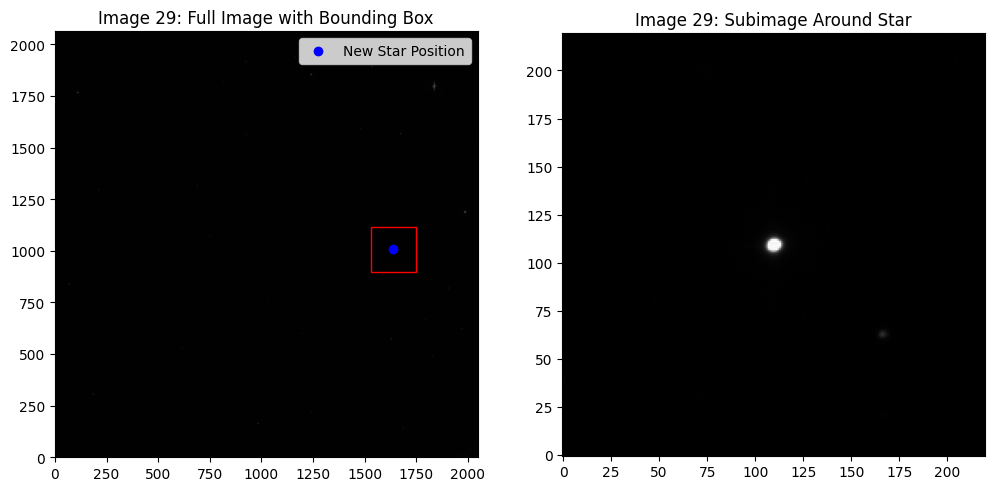

 Aligning image 29/33
    Offset : (87, -6)


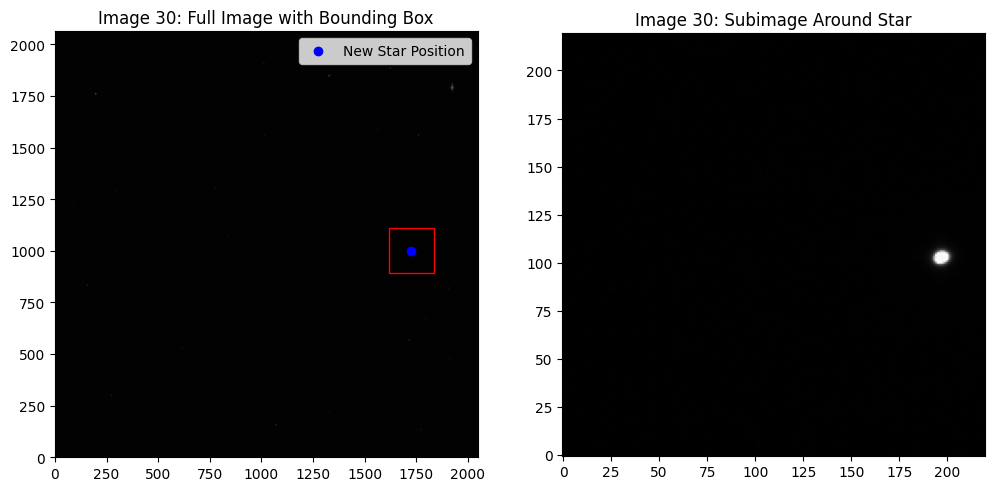

 Aligning image 30/33
    Offset : (0, 0)


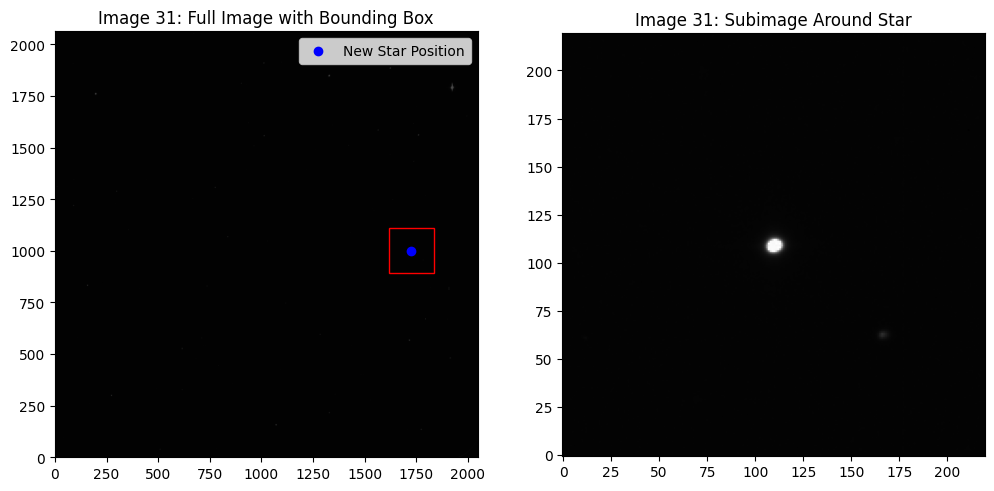

 Aligning image 31/33
    Offset : (-28, -32)


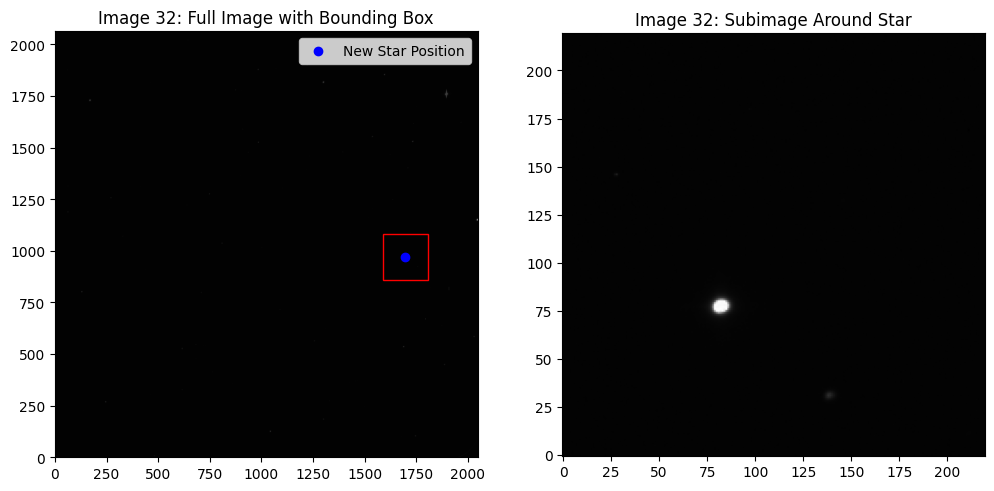

 Aligning image 32/33
    Offset : (0, 0)


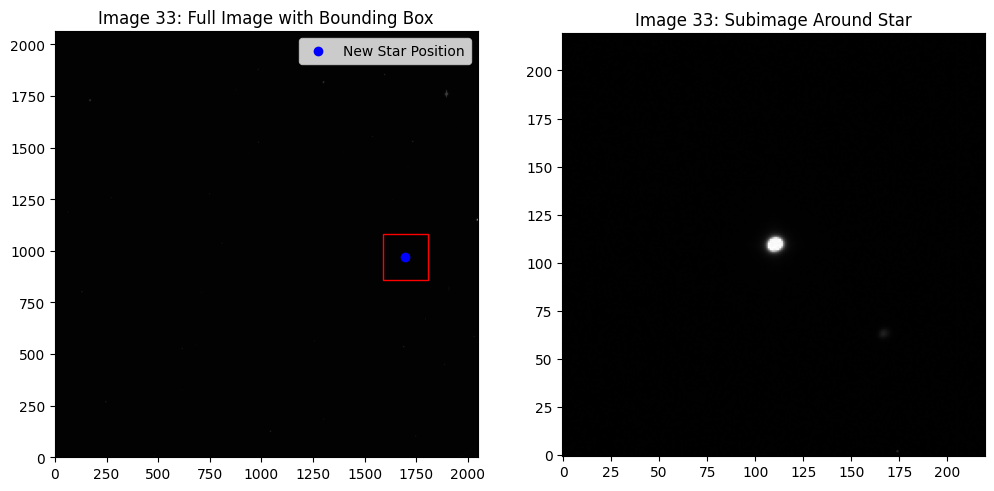

[(0, 0), (-1, -1), (-5, 33), (-5, 34), (-5, 34), (-4, 34), (-4, 34), (-4, 34), (-4, 34), (-4, 34), (-3, 34), (-3, 34), (-110, 29), (-112, 29), (-115, -20), (-115, -20), (-72, 7), (-72, 7), (-68, -17), (-68, -17), (15, 14), (15, 14), (15, 15), (15, 14), (-17, -80), (-17, -80), (-16, -80), (-46, -84), (-46, -84), (41, -90), (41, -90), (13, -122), (13, -122)]


In [20]:
# List of files
Ns = [
    "0066",
    "0068",
    "0070",
    "0072",
    "0074",
    "0076",
    "0078",
    "0080",
    "0082",
    "0084",
    "0086",
    "0088",
    "0090",
    "0092",
    "0094",
    "0096",
    "0103",
    "0105",
    "0107",
    "0109",
    "0117",
    "0119",
    "0121",
    "0123",
    "0128",
    "0130",
    "0134",
    "0136",
    "0138",
    "0143",
    "0145",
    "0147",
    "0149",
    # "0151",
    # "0153", # Shitty image
    ]
files = [
    f'data/9_Oct/td10r_n3_{i}.fits' for i in Ns
]

print(files)
# Get array of offsets

Ref_star = (1685, 1091)
bounding = 110

relative_offsets = CreateOffsetArray(files, Ref_star, bounding, Debug=True, Verbose=True)


# Compute the absolute offsets
absolute_offsets = compute_absolute_offsets(relative_offsets)

print(absolute_offsets)

absolute offset of the last frame : (13, -122)


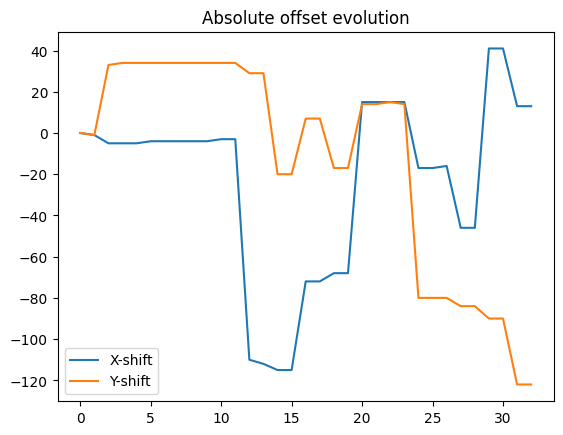

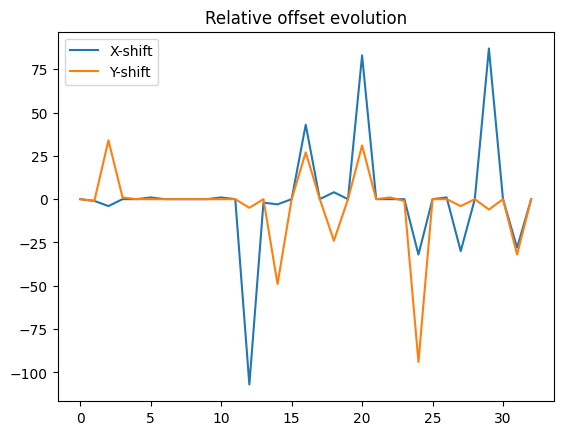

In [21]:
print(f'absolute offset of the last frame : {absolute_offsets[-1]}')

plt.plot([i for i in range(len(absolute_offsets))],[i[0] for i in absolute_offsets], label="X-shift")
plt.plot([i for i in range(len(absolute_offsets))],[i[1] for i in absolute_offsets], label="Y-shift")
plt.legend()
plt.title("Absolute offset evolution")
plt.show()

plt.plot([i for i in range(len(relative_offsets))],[i[0] for i in relative_offsets], label="X-shift")
plt.plot([i for i in range(len(relative_offsets))],[i[1] for i in relative_offsets], label="Y-shift")
plt.legend()
plt.title("Relative offset evolution")
plt.show()

The above part computes the relative and absolute offsets of each images. Now we will use the provided code to compute the mag.

manual data 9_Oct : 
```
66 : (1513, 863) = start

149: (1841, 602)  =>  (1829, 724)
151: (1856, 597)  =>  (1843, 719) = end
```

Using last image offset from first image we get the positions for the first and last frame.

In [22]:
def PositionInterpolation( start, end, sample_positions):
        # Extract starting and ending coordinates
    x_start, y_start = start
    x_end, y_end = end
    
    # Compute the step size for each frame (linear interpolation)
    x_step = (x_end - x_start) / (sample_positions - 1)
    y_step = (y_end - y_start) / (sample_positions - 1)
    
    # Generate the positions for each frame
    positions = [(x_start + i * x_step, y_start + i * y_step) for i in range(sample_positions)]
    
    return positions

0
Filename: data/9_Oct/td10r_n3_0066.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      99   (2048, 2063)   float32   
data shape :  (2063, 2048)
mjd :  52191.0812616
exposition :  180.0  secs
resultats centroid =21.982 ,24.053
 id      xcenter            ycenter      aperture_sum
           pix                pix                    
--- ------------------ ----------------- ------------
  1 21.981575342550762 24.05328964116658    171637.62

Sum_target_raw=171637.618

 id      xcenter            ycenter      aperture_sum
           pix                pix                    
--- ------------------ ----------------- ------------
  1 21.981575342550762 24.05328964116658     349576.2

Sky_background=349576.197

Target flux without sky=14328.329

instrumental magnitude=-10.390

349576.19734906196


/tmp/ipykernel_432921/2393849239.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_432921/2393849239.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_432921/2393849239.py:81: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_432921/239384

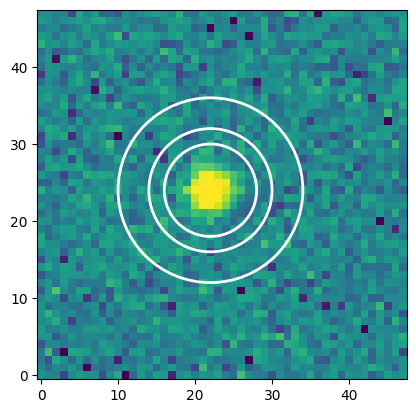

{'mjd': 52191.0812616, 'exptime': 180.0, 'magnitude': -10.390488841920128, 'sky': -9.101129667140839}
1
Filename: data/9_Oct/td10r_n3_0068.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      99   (2048, 2063)   float32   
data shape :  (2063, 2048)
mjd :  52191.0882986
exposition :  180.0  secs
resultats centroid =22.137 ,26.078
 id      xcenter            ycenter       aperture_sum
           pix                pix                     
--- ------------------ ------------------ ------------
  1 22.137271284929472 26.077550986065056    167197.15

Sum_target_raw=167197.152

 id      xcenter            ycenter       aperture_sum
           pix                pix                     
--- ------------------ ------------------ ------------
  1 22.137271284929472 26.077550986065056     338953.3

Sky_background=338953.299

Target flux without sky=14668.168

instrumental magnitude=-10.416

338953.2988153844


/tmp/ipykernel_432921/2393849239.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_432921/2393849239.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_432921/2393849239.py:81: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_432921/239384

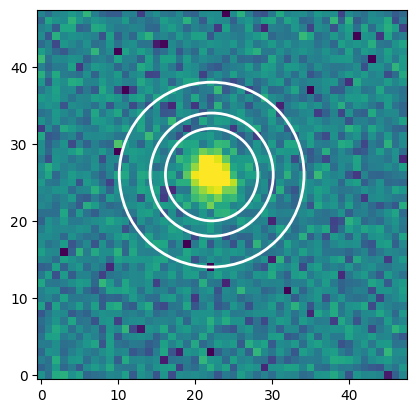

{'mjd': 52191.0882986, 'exptime': 180.0, 'magnitude': -10.415939670155423, 'sky': -9.067624694960367}
2
Filename: data/9_Oct/td10r_n3_0070.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      99   (2048, 2063)   float32   
data shape :  (2063, 2048)
mjd :  52191.0955671
exposition :  180.0  secs
resultats centroid =22.425 ,25.399


/tmp/ipykernel_432921/2393849239.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))


 id      xcenter            ycenter       aperture_sum
           pix                pix                     
--- ------------------ ------------------ ------------
  1 22.425287493415592 25.399252200992517    161358.16

Sum_target_raw=161358.160

 id      xcenter            ycenter       aperture_sum
           pix                pix                     
--- ------------------ ------------------ ------------
  1 22.425287493415592 25.399252200992517    324571.88

Sky_background=324571.880

Target flux without sky=15300.814

instrumental magnitude=-10.462

324571.8795433115


/tmp/ipykernel_432921/2393849239.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_432921/2393849239.py:81: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_432921/2393849239.py:82: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Magnitude=-2.5*log10(Sum_target)
/tmp/ipykernel_432921/2393849239.py:86: DeprecationWarn

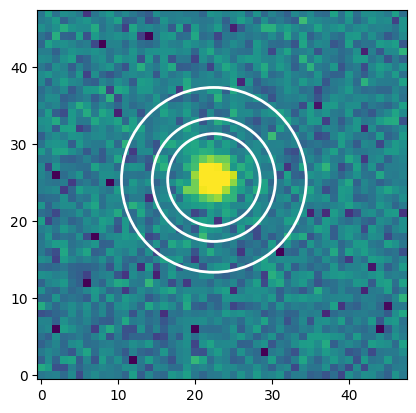

{'mjd': 52191.0955671, 'exptime': 180.0, 'magnitude': -10.461786327762088, 'sky': -9.020552258644067}
3
Filename: data/9_Oct/td10r_n3_0072.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      99   (2048, 2063)   float32   
data shape :  (2063, 2048)
mjd :  52191.1022338
exposition :  180.0  secs
resultats centroid =11.203 ,41.107
 id      xcenter            ycenter      aperture_sum
           pix                pix                    
--- ------------------ ----------------- ------------
  1 11.203433344859189 41.10657270295823    150374.31

Sum_target_raw=150374.309

 id      xcenter            ycenter      aperture_sum
           pix                pix                    
--- ------------------ ----------------- ------------
  1 11.203433344859189 41.10657270295823    230534.67

Sky_background=230534.669

Target flux without sky=46633.708

instrumental magnitude=-11.672

230534.6691451226


/tmp/ipykernel_432921/2393849239.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_432921/2393849239.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_432921/2393849239.py:81: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_432921/239384

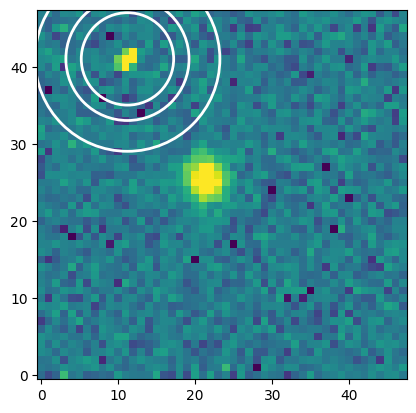

{'mjd': 52191.1022338, 'exptime': 180.0, 'magnitude': -11.671749865256487, 'sky': -8.649115648441807}
4
Filename: data/9_Oct/td10r_n3_0074.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      97   (2048, 2063)   float32   
data shape :  (2063, 2048)
mjd :  52191.1095139
exposition :  180.0  secs
resultats centroid =21.878 ,24.914
 id      xcenter            ycenter       aperture_sum
           pix                pix                     
--- ------------------ ------------------ ------------
  1 21.877997047140923 24.914251536900995    159177.49

Sum_target_raw=159177.493

 id      xcenter            ycenter       aperture_sum
           pix                pix                     
--- ------------------ ------------------ ------------
  1 21.877997047140923 24.914251536900995    319988.38

Sky_background=319988.379

Target flux without sky=15182.722

instrumental magnitude=-10.453

319988.3790700104


/tmp/ipykernel_432921/2393849239.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_432921/2393849239.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_432921/2393849239.py:81: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_432921/239384

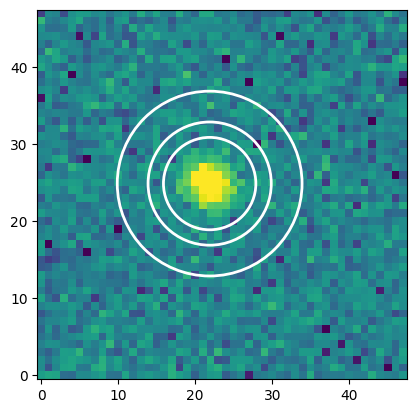

{'mjd': 52191.1095139, 'exptime': 180.0, 'magnitude': -10.453374108822452, 'sky': -9.005110548652628}
5
Filename: data/9_Oct/td10r_n3_0076.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      99   (2048, 2063)   float32   


/tmp/ipykernel_432921/2393849239.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_432921/2393849239.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_432921/2393849239.py:81: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_432921/239384

data shape :  (2063, 2048)
mjd :  52191.1162153
exposition :  180.0  secs
resultats centroid =14.004 ,41.910
 id      xcenter            ycenter       aperture_sum
           pix                pix                     
--- ------------------ ------------------ ------------
  1 14.003712765562078 41.909564779919585    140834.69

Sum_target_raw=140834.688

 id      xcenter            ycenter       aperture_sum
           pix                pix                     
--- ------------------ ------------------ ------------
  1 14.003712765562078 41.909564779919585    214866.65

Sky_background=214866.646

Target flux without sky=44144.697

instrumental magnitude=-11.612

214866.64560427


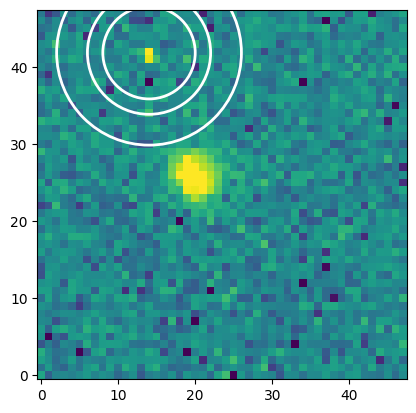

{'mjd': 52191.1162153, 'exptime': 180.0, 'magnitude': -11.612196360976688, 'sky': -8.572697542232014}
6
Filename: data/9_Oct/td10r_n3_0078.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      99   (2048, 2063)   float32   
data shape :  (2063, 2048)
mjd :  52191.1234954
exposition :  180.0  secs
resultats centroid =19.710 ,26.233
 id      xcenter            ycenter      aperture_sum
           pix                pix                    
--- ------------------ ----------------- ------------
  1 19.709606501853745 26.23288925654396    149694.37

Sum_target_raw=149694.366

 id      xcenter            ycenter      aperture_sum
           pix                pix                    
--- ------------------ ----------------- ------------
  1 19.709606501853745 26.23288925654396     298017.2

Sky_background=298017.197

Target flux without sky=15586.628

instrumental magnitude=-10.482

298017.1969015347


/tmp/ipykernel_432921/2393849239.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_432921/2393849239.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_432921/2393849239.py:81: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_432921/239384

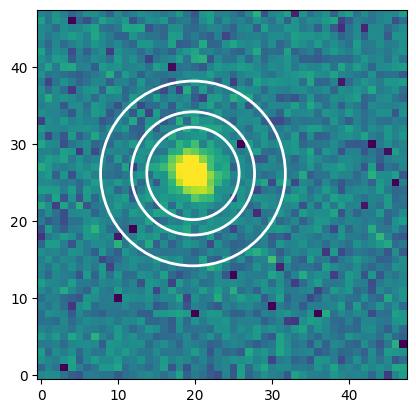

{'mjd': 52191.1234954, 'exptime': 180.0, 'magnitude': -10.481880401311614, 'sky': -8.927878346267448}
7
Filename: data/9_Oct/td10r_n3_0080.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      99   (2048, 2063)   float32   
data shape :  (2063, 2048)
mjd :  52191.130162
exposition :  180.0  secs
resultats centroid =9.746 ,40.013
 id      xcenter           ycenter       aperture_sum
           pix               pix                     
--- ----------------- ------------------ ------------
  1 9.745973236161577 40.012743987845475    139684.32

Sum_target_raw=139684.318

 id      xcenter           ycenter       aperture_sum
           pix               pix                     
--- ----------------- ------------------ ------------
  1 9.745973236161577 40.012743987845475    218299.44

Sky_background=218299.444

Target flux without sky=41449.568

instrumental magnitude=-11.544

218299.4439790417


/tmp/ipykernel_432921/2393849239.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_432921/2393849239.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_432921/2393849239.py:81: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_432921/239384

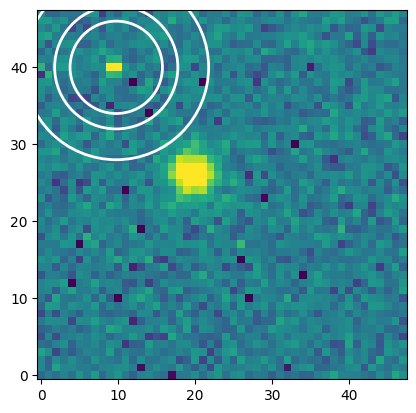

{'mjd': 52191.130162, 'exptime': 180.0, 'magnitude': -11.543800024545018, 'sky': -8.589906606365348}
8
Filename: data/9_Oct/td10r_n3_0082.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      99   (2048, 2063)   float32   
data shape :  (2063, 2048)
mjd :  52191.1374537
exposition :  180.0  secs
resultats centroid =18.816 ,26.547
 id      xcenter            ycenter      aperture_sum
           pix                pix                    
--- ------------------ ----------------- ------------
  1 18.815719435969246 26.54650548583522    149439.71

Sum_target_raw=149439.712

 id      xcenter            ycenter      aperture_sum
           pix                pix                    
--- ------------------ ----------------- ------------
  1 18.815719435969246 26.54650548583522    296667.77

Sky_background=296667.773

Target flux without sky=15939.214

instrumental magnitude=-10.506

296667.77283001674


/tmp/ipykernel_432921/2393849239.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_432921/2393849239.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_432921/2393849239.py:81: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_432921/239384

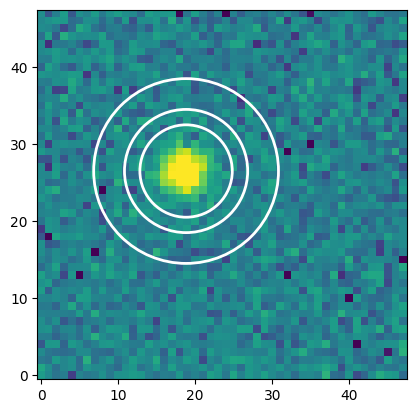

{'mjd': 52191.1374537, 'exptime': 180.0, 'magnitude': -10.506167264265759, 'sky': -8.92295096064571}
9
Filename: data/9_Oct/td10r_n3_0084.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      99   (2048, 2063)   float32   
data shape :  (2063, 2048)
mjd :  52191.1441319
exposition :  180.0  secs
resultats centroid =18.020 ,26.503
 id      xcenter            ycenter       aperture_sum
           pix                pix                     
--- ------------------ ------------------ ------------
  1 18.019675996926715 26.502858935377258    149884.07

Sum_target_raw=149884.072

 id      xcenter            ycenter       aperture_sum
           pix                pix                     
--- ------------------ ------------------ ------------
  1 18.019675996926715 26.502858935377258     297341.1

Sky_background=297341.102

Target flux without sky=16080.576

instrumental magnitude=-10.516

297341.10242798855


/tmp/ipykernel_432921/2393849239.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_432921/2393849239.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_432921/2393849239.py:81: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_432921/239384

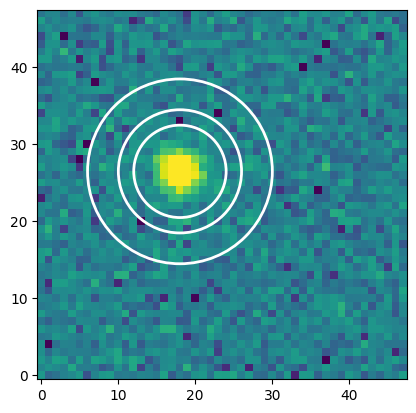

{'mjd': 52191.1441319, 'exptime': 180.0, 'magnitude': -10.515753990719052, 'sky': -8.925412400754828}
10
Filename: data/9_Oct/td10r_n3_0086.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      99   (2048, 2063)   float32   
data shape :  (2063, 2048)
mjd :  52191.1514583
exposition :  180.0  secs
resultats centroid =17.488 ,26.883
 id      xcenter            ycenter       aperture_sum
           pix                pix                     
--- ------------------ ------------------ ------------
  1 17.487784120738464 26.883445087543038    152149.62

Sum_target_raw=152149.623

 id      xcenter            ycenter       aperture_sum
           pix                pix                     
--- ------------------ ------------------ ------------
  1 17.487784120738464 26.883445087543038    298892.97

Sky_background=298892.966

Target flux without sky=17647.788

instrumental magnitude=-10.617

298892.96631227154


/tmp/ipykernel_432921/2393849239.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_432921/2393849239.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_432921/2393849239.py:81: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_432921/239384

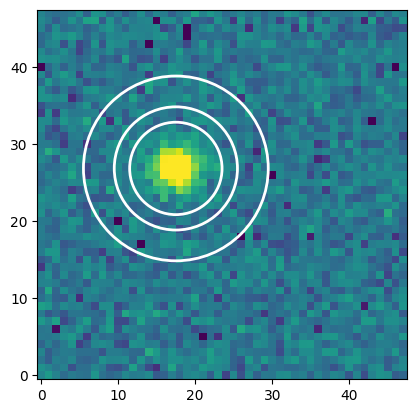

{'mjd': 52191.1514583, 'exptime': 180.0, 'magnitude': -10.61672569671741, 'sky': -8.931064270371689}
11
Filename: data/9_Oct/td10r_n3_0088.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      99   (2048, 2063)   float32   
data shape :  (2063, 2048)
mjd :  52191.1581481
exposition :  180.0  secs
resultats centroid =16.375 ,27.252
 id      xcenter            ycenter       aperture_sum
           pix                pix                     
--- ------------------ ------------------ ------------
  1 16.375153570446013 27.252152737683588    153675.48

Sum_target_raw=153675.482

 id      xcenter            ycenter       aperture_sum
           pix                pix                     
--- ------------------ ------------------ ------------
  1 16.375153570446013 27.252152737683588     298880.8

Sky_background=298880.804

Target flux without sky=19179.120

instrumental magnitude=-10.707

298880.80406697444


/tmp/ipykernel_432921/2393849239.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_432921/2393849239.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_432921/2393849239.py:81: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_432921/239384

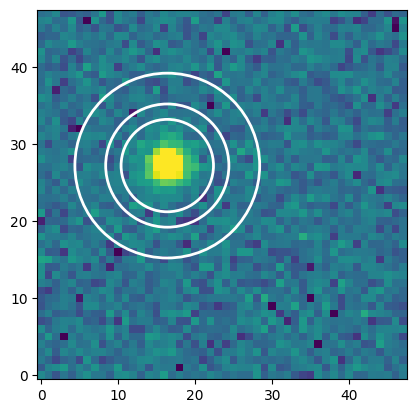

{'mjd': 52191.1581481, 'exptime': 180.0, 'magnitude': -10.707071684047298, 'sky': -8.931020089811398}
12
Filename: data/9_Oct/td10r_n3_0090.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      99   (2048, 2063)   float32   


/tmp/ipykernel_432921/2393849239.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_432921/2393849239.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_432921/2393849239.py:81: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_432921/239384

data shape :  (2063, 2048)
mjd :  52191.1654167
exposition :  180.0  secs
resultats centroid =13.962 ,27.253
 id      xcenter            ycenter       aperture_sum
           pix                pix                     
--- ------------------ ------------------ ------------
  1 13.962432370426876 27.252563668626237    150908.54

Sum_target_raw=150908.542

 id      xcenter            ycenter       aperture_sum
           pix                pix                     
--- ------------------ ------------------ ------------
  1 13.962432370426876 27.252563668626237    294477.07

Sky_background=294477.069

Target flux without sky=18393.861

instrumental magnitude=-10.662

294477.06861038366


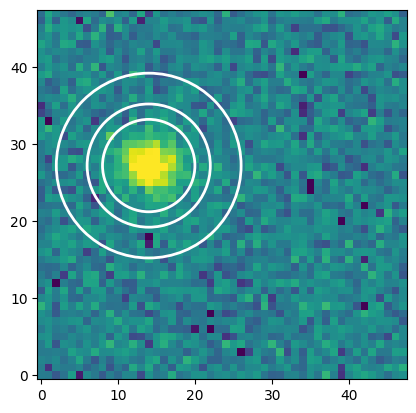

{'mjd': 52191.1654167, 'exptime': 180.0, 'magnitude': -10.661682233808502, 'sky': -8.914903735644383}
13
Filename: data/9_Oct/td10r_n3_0092.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      99   (2048, 2063)   float32   
data shape :  (2063, 2048)
mjd :  52191.1720949
exposition :  180.0  secs
resultats centroid =16.592 ,27.831


/tmp/ipykernel_432921/2393849239.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_432921/2393849239.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_432921/2393849239.py:81: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_432921/239384

 id      xcenter           ycenter       aperture_sum
           pix               pix                     
--- ----------------- ------------------ ------------
  1 16.59214593619806 27.830957099956876    149534.63

Sum_target_raw=149534.631

 id      xcenter           ycenter       aperture_sum
           pix               pix                     
--- ----------------- ------------------ ------------
  1 16.59214593619806 27.830957099956876    291623.45

Sky_background=291623.451

Target flux without sky=18304.078

instrumental magnitude=-10.656

291623.4513628369


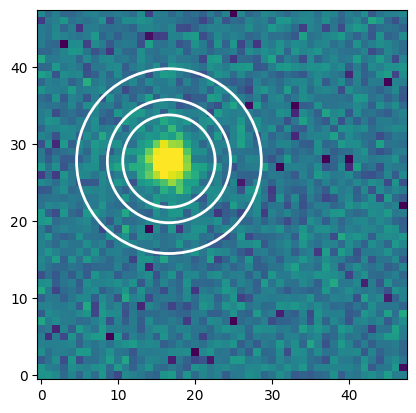

{'mjd': 52191.1720949, 'exptime': 180.0, 'magnitude': -10.656369637055235, 'sky': -8.904331146346479}
14
Filename: data/9_Oct/td10r_n3_0094.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      99   (2048, 2063)   float32   
data shape :  (2063, 2048)
mjd :  52191.1793403
exposition :  180.0  secs
resultats centroid =15.305 ,27.410
 id      xcenter            ycenter      aperture_sum
           pix                pix                    
--- ------------------ ----------------- ------------
  1 15.304638559924804 27.40950944556461    148976.69

Sum_target_raw=148976.694

 id      xcenter            ycenter      aperture_sum
           pix                pix                    
--- ------------------ ----------------- ------------
  1 15.304638559924804 27.40950944556461    287338.18

Sky_background=287338.177

Target flux without sky=19674.514

instrumental magnitude=-10.735

287338.17748302425


/tmp/ipykernel_432921/2393849239.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_432921/2393849239.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_432921/2393849239.py:81: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_432921/239384

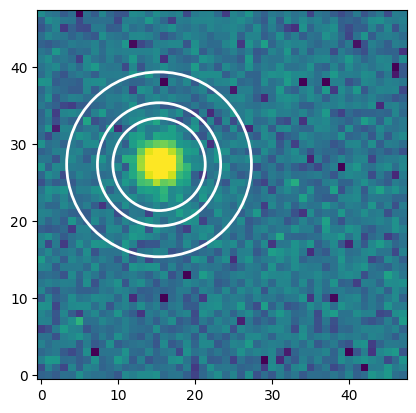

{'mjd': 52191.1793403, 'exptime': 180.0, 'magnitude': -10.734760026002007, 'sky': -8.888258364543905}
15
Filename: data/9_Oct/td10r_n3_0096.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      99   (2048, 2063)   float32   
data shape :  (2063, 2048)
mjd :  52191.1860301
exposition :  180.0  secs
resultats centroid =15.811 ,28.132
 id      xcenter          ycenter     aperture_sum
           pix              pix                   
--- ----------------- --------------- ------------
  1 15.81134658289833 28.131525755558    152582.63

Sum_target_raw=152582.631

 id      xcenter          ycenter     aperture_sum
           pix              pix                   
--- ----------------- --------------- ------------
  1 15.81134658289833 28.131525755558    291915.89

Sky_background=291915.890

Target flux without sky=21220.480

instrumental magnitude=-10.817

291915.8895580695


/tmp/ipykernel_432921/2393849239.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_432921/2393849239.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_432921/2393849239.py:81: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_432921/239384

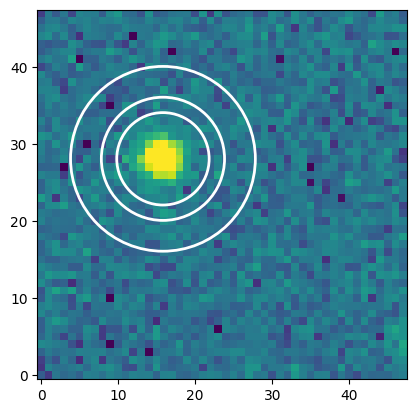

{'mjd': 52191.1860301, 'exptime': 180.0, 'magnitude': -10.816888031310988, 'sky': -8.905419370363383}
16
Filename: data/9_Oct/td10r_n3_0103.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      99   (2048, 2063)   float32   
data shape :  (2063, 2048)
mjd :  52191.2035069
exposition :  180.0  secs
resultats centroid =18.805 ,25.991
 id      xcenter           ycenter      aperture_sum
           pix               pix                    
--- ----------------- ----------------- ------------
  1 18.80539399139056 25.99058786740011    173586.36

Sum_target_raw=173586.362

 id      xcenter           ycenter      aperture_sum
           pix               pix                    
--- ----------------- ----------------- ------------
  1 18.80539399139056 25.99058786740011    334746.34

Sky_background=334746.343

Target flux without sky=22950.508

instrumental magnitude=-10.902

334746.34349645383


/tmp/ipykernel_432921/2393849239.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_432921/2393849239.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_432921/2393849239.py:81: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_432921/239384

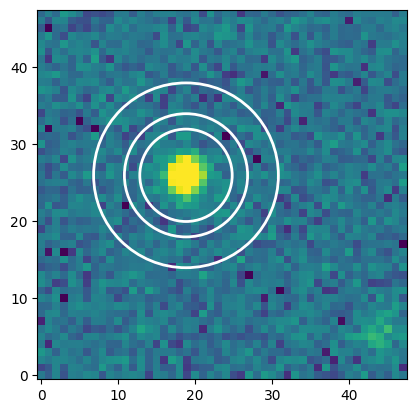

{'mjd': 52191.2035069, 'exptime': 180.0, 'magnitude': -10.901980752662832, 'sky': -9.054064637073902}
17
Filename: data/9_Oct/td10r_n3_0105.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      99   (2048, 2063)   float32   
data shape :  (2063, 2048)
mjd :  52191.2101968
exposition :  180.0  secs
resultats centroid =17.979 ,25.975
 id      xcenter            ycenter       aperture_sum
           pix                pix                     
--- ------------------ ------------------ ------------
  1 17.979471105379687 25.975045813833756    184471.87

Sum_target_raw=184471.867

 id      xcenter            ycenter       aperture_sum
           pix                pix                     
--- ------------------ ------------------ ------------
  1 17.979471105379687 25.975045813833756    359852.53

Sky_background=359852.527

Target flux without sky=22538.230

instrumental magnitude=-10.882

359852.52725090075


/tmp/ipykernel_432921/2393849239.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_432921/2393849239.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_432921/2393849239.py:81: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_432921/239384

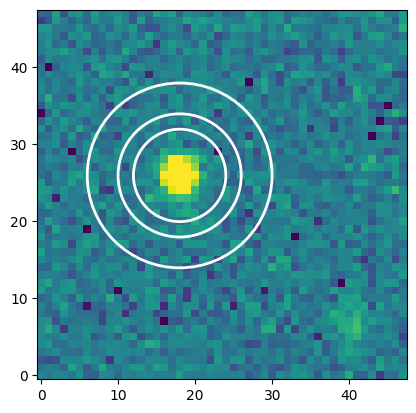

{'mjd': 52191.2101968, 'exptime': 180.0, 'magnitude': -10.88229950867179, 'sky': -9.132586425250981}
18
Filename: data/9_Oct/td10r_n3_0107.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      97   (2048, 2063)   float32   
data shape :  (2063, 2048)
mjd :  52191.2179977
exposition :  180.0  secs
resultats centroid =18.127 ,25.974
 id      xcenter           ycenter       aperture_sum
           pix               pix                     
--- ----------------- ------------------ ------------
  1 18.12720170562693 25.973574905200465    193145.12

Sum_target_raw=193145.120

 id      xcenter           ycenter       aperture_sum
           pix               pix                     
--- ----------------- ------------------ ------------
  1 18.12720170562693 25.973574905200465     375276.5

Sky_background=375276.504

Target flux without sky=24270.693

instrumental magnitude=-10.963

375276.50379342807


/tmp/ipykernel_432921/2393849239.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_432921/2393849239.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_432921/2393849239.py:81: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_432921/239384

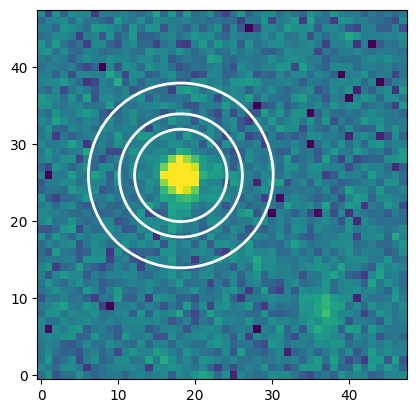

{'mjd': 52191.2179977, 'exptime': 180.0, 'magnitude': -10.962705446541632, 'sky': -9.178153467318502}
19
Filename: data/9_Oct/td10r_n3_0109.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      99   (2048, 2063)   float32   
data shape :  (2063, 2048)
mjd :  52191.2246759
exposition :  180.0  secs
resultats centroid =17.229 ,25.693
 id      xcenter            ycenter      aperture_sum
           pix                pix                    
--- ------------------ ----------------- ------------
  1 17.228993314218975 25.69309912354056    201014.54

Sum_target_raw=201014.540

 id      xcenter            ycenter      aperture_sum
           pix                pix                    
--- ------------------ ----------------- ------------
  1 17.228993314218975 25.69309912354056    391331.98

Sky_background=391331.979

Target flux without sky=24915.149

instrumental magnitude=-10.991

391331.97937333456


/tmp/ipykernel_432921/2393849239.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_432921/2393849239.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_432921/2393849239.py:81: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_432921/239384

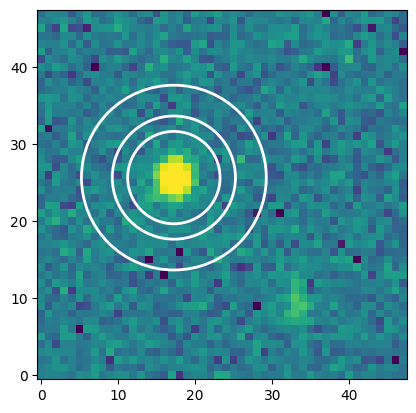

{'mjd': 52191.2246759, 'exptime': 180.0, 'magnitude': -10.991158723598126, 'sky': -9.223638381494181}
20
Filename: data/9_Oct/td10r_n3_0117.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      99   (2048, 2063)   float32   
data shape :  (2063, 2048)
mjd :  52191.2417014
exposition :  180.0  secs
resultats centroid =21.732 ,24.805
 id      xcenter           ycenter       aperture_sum
           pix               pix                     
--- ----------------- ------------------ ------------
  1 21.73218226592447 24.804779054677525    213240.92

Sum_target_raw=213240.925

 id      xcenter           ycenter       aperture_sum
           pix               pix                     
--- ----------------- ------------------ ------------
  1 21.73218226592447 24.804779054677525    421119.02

Sky_background=421119.020

Target flux without sky=23737.366

instrumental magnitude=-10.939

421119.0203870855


/tmp/ipykernel_432921/2393849239.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_432921/2393849239.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_432921/2393849239.py:81: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_432921/239384

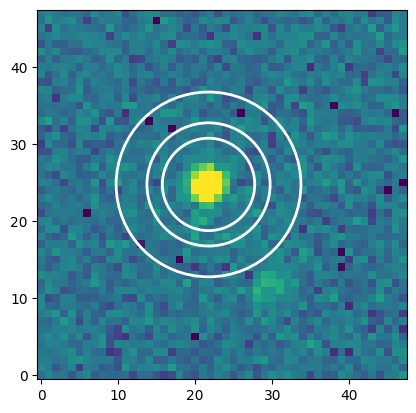

{'mjd': 52191.2417014, 'exptime': 180.0, 'magnitude': -10.938581297234544, 'sky': -9.303287175863046}
21
Filename: data/9_Oct/td10r_n3_0119.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      99   (2048, 2063)   float32   


/tmp/ipykernel_432921/2393849239.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_432921/2393849239.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_432921/2393849239.py:81: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_432921/239384

data shape :  (2063, 2048)
mjd :  52191.2485069
exposition :  180.0  secs
resultats centroid =20.862 ,24.716
 id      xcenter           ycenter      aperture_sum
           pix               pix                    
--- ------------------ ---------------- ------------
  1 20.862090585046023 24.7164622310652    213877.12

Sum_target_raw=213877.121

 id      xcenter           ycenter      aperture_sum
           pix               pix                    
--- ------------------ ---------------- ------------
  1 20.862090585046023 24.7164622310652    424066.03

Sky_background=424066.028

Target flux without sky=23047.408

instrumental magnitude=-10.907

424066.02797876275


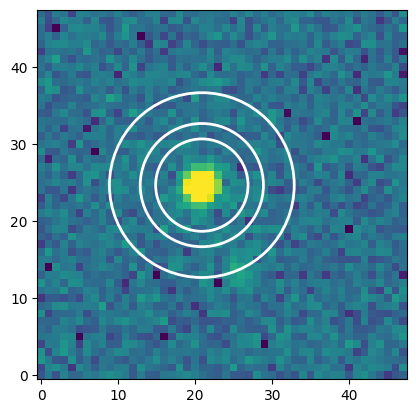

{'mjd': 52191.2485069, 'exptime': 180.0, 'magnitude': -10.906555239783184, 'sky': -9.31085873859093}
22
Filename: data/9_Oct/td10r_n3_0121.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      99   (2048, 2063)   float32   
data shape :  (2063, 2048)
mjd :  52191.2558333
exposition :  180.0  secs
resultats centroid =20.091 ,24.180
 id     xcenter           ycenter       aperture_sum
          pix               pix                     
--- ---------------- ------------------ ------------
  1 20.0914768034154 24.180262774526142    220313.02

Sum_target_raw=220313.024

 id     xcenter           ycenter       aperture_sum
          pix               pix                     
--- ---------------- ------------------ ------------
  1 20.0914768034154 24.180262774526142    436845.52

Sky_background=436845.524

Target flux without sky=23732.539

instrumental magnitude=-10.938

436845.5239767768


/tmp/ipykernel_432921/2393849239.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_432921/2393849239.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_432921/2393849239.py:81: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_432921/239384

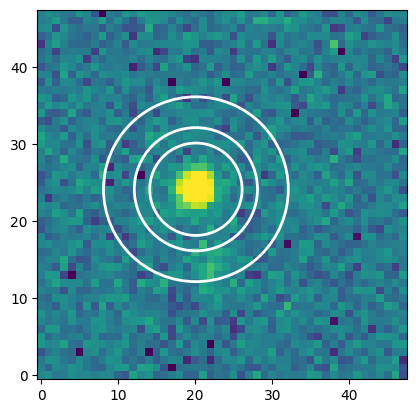

{'mjd': 52191.2558333, 'exptime': 180.0, 'magnitude': -10.938360485369905, 'sky': -9.343094757984986}
23
Filename: data/9_Oct/td10r_n3_0123.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      99   (2048, 2063)   float32   
data shape :  (2063, 2048)
mjd :  52191.2625116
exposition :  180.0  secs
resultats centroid =20.292 ,25.915
 id      xcenter            ycenter      aperture_sum
           pix                pix                    
--- ------------------ ----------------- ------------
  1 20.291571181731193 25.91472978739866    225557.66

Sum_target_raw=225557.663

 id      xcenter            ycenter      aperture_sum
           pix                pix                    
--- ------------------ ----------------- ------------
  1 20.291571181731193 25.91472978739866    446275.31

Sky_background=446275.310

Target flux without sky=24733.774

instrumental magnitude=-10.983

446275.30963299447


/tmp/ipykernel_432921/2393849239.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_432921/2393849239.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_432921/2393849239.py:81: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_432921/239384

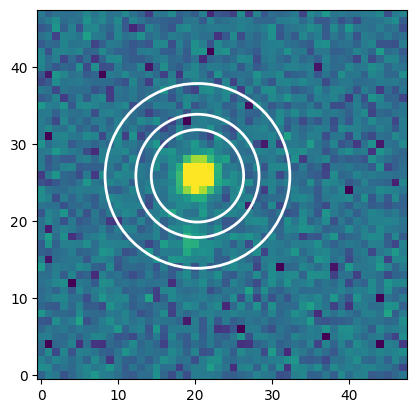

{'mjd': 52191.2625116, 'exptime': 180.0, 'magnitude': -10.983225973731436, 'sky': -9.36628218247624}
24
Filename: data/9_Oct/td10r_n3_0128.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      99   (2048, 2063)   float32   
data shape :  (2063, 2048)
mjd :  52191.2747222
exposition :  180.0  secs
resultats centroid =21.883 ,23.832
 id      xcenter           ycenter      aperture_sum
           pix               pix                    
--- ----------------- ----------------- ------------
  1 21.88298215501972 23.83174993751138    230497.39

Sum_target_raw=230497.389

 id      xcenter           ycenter      aperture_sum
           pix               pix                    
--- ----------------- ----------------- ------------
  1 21.88298215501972 23.83174993751138    459238.99

Sky_background=459238.986

Target flux without sky=23839.845

instrumental magnitude=-10.943

459238.9863431375


/tmp/ipykernel_432921/2393849239.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_432921/2393849239.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_432921/2393849239.py:81: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_432921/239384

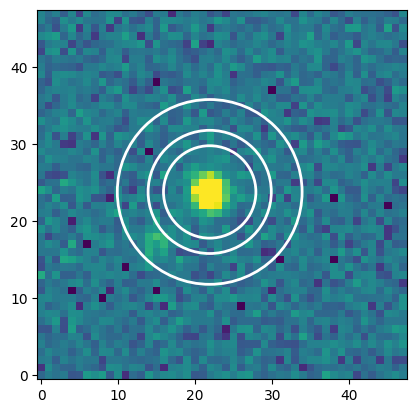

{'mjd': 52191.2747222, 'exptime': 180.0, 'magnitude': -10.943258557917126, 'sky': -9.397371906708052}
25
Filename: data/9_Oct/td10r_n3_0130.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      99   (2048, 2063)   float32   
data shape :  (2063, 2048)
mjd :  52191.2815278
exposition :  180.0  secs
resultats centroid =21.000 ,24.546
 id      xcenter            ycenter       aperture_sum
           pix                pix                     
--- ------------------ ------------------ ------------
  1 20.999793053851196 24.546114212827128    232809.56

Sum_target_raw=232809.565

 id      xcenter            ycenter       aperture_sum
           pix                pix                     
--- ------------------ ------------------ ------------
  1 20.999793053851196 24.546114212827128    464348.94

Sky_background=464348.937

Target flux without sky=23852.543

instrumental magnitude=-10.944

464348.9365707477


/tmp/ipykernel_432921/2393849239.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_432921/2393849239.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_432921/2393849239.py:81: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_432921/239384

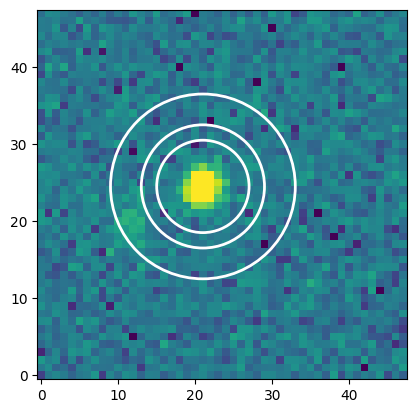

{'mjd': 52191.2815278, 'exptime': 180.0, 'magnitude': -10.943836722459004, 'sky': -9.409386170733097}
26
Filename: data/9_Oct/td10r_n3_0134.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      99   (2048, 2063)   float32   
data shape :  (2063, 2048)
mjd :  52191.2954861
exposition :  180.0  secs
resultats centroid =23.344 ,22.636
 id      xcenter            ycenter       aperture_sum
           pix                pix                     
--- ------------------ ------------------ ------------
  1 23.343791781627544 22.635875459046463     240680.3

Sum_target_raw=240680.301

 id      xcenter            ycenter       aperture_sum
           pix                pix                     
--- ------------------ ------------------ ------------
  1 23.343791781627544 22.635875459046463    481613.89

Sky_background=481613.887

Target flux without sky=23954.052

instrumental magnitude=-10.948

481613.8866664431


/tmp/ipykernel_432921/2393849239.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_432921/2393849239.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_432921/2393849239.py:81: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_432921/239384

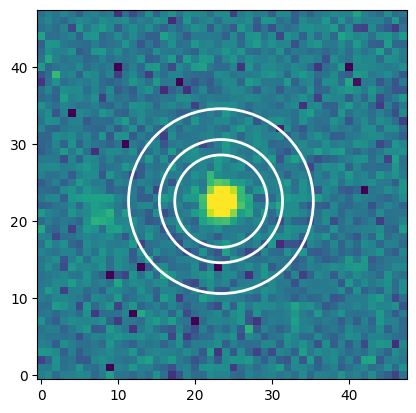

{'mjd': 52191.2954861, 'exptime': 180.0, 'magnitude': -10.948447489531166, 'sky': -9.44902253428898}
27
Filename: data/9_Oct/td10r_n3_0136.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      99   (2048, 2063)   float32   
data shape :  (2063, 2048)
mjd :  52191.3027778
exposition :  180.0  secs
resultats centroid =22.900 ,23.049
 id      xcenter            ycenter      aperture_sum
           pix                pix                    
--- ------------------ ----------------- ------------
  1 22.900246091983455 23.04920185427975    246216.54

Sum_target_raw=246216.540

 id      xcenter            ycenter      aperture_sum
           pix                pix                    
--- ------------------ ----------------- ------------
  1 22.900246091983455 23.04920185427975     495974.8

Sky_background=495974.799

Target flux without sky=23027.880

instrumental magnitude=-10.906

495974.7994572098


/tmp/ipykernel_432921/2393849239.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_432921/2393849239.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_432921/2393849239.py:81: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_432921/239384

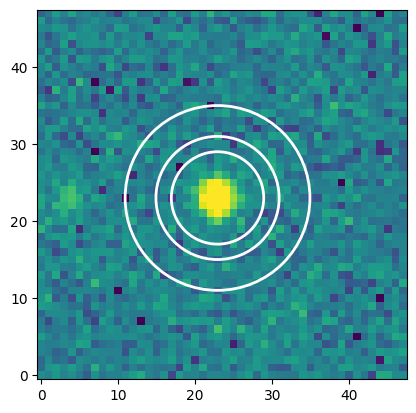

{'mjd': 52191.3027778, 'exptime': 180.0, 'magnitude': -10.905634890520481, 'sky': -9.480924058752114}
28
Filename: data/9_Oct/td10r_n3_0138.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      99   (2048, 2063)   float32   
data shape :  (2063, 2048)
mjd :  52191.3094444
exposition :  180.0  secs
resultats centroid =21.963 ,23.938
 id      xcenter            ycenter       aperture_sum
           pix                pix                     
--- ------------------ ------------------ ------------
  1 21.963471686850887 23.938234048134014    253216.33

Sum_target_raw=253216.328

 id      xcenter            ycenter       aperture_sum
           pix                pix                     
--- ------------------ ------------------ ------------
  1 21.963471686850887 23.938234048134014    511299.06

Sky_background=511299.062

Target flux without sky=23131.750

instrumental magnitude=-10.911

511299.06227268686


/tmp/ipykernel_432921/2393849239.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_432921/2393849239.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_432921/2393849239.py:81: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_432921/239384

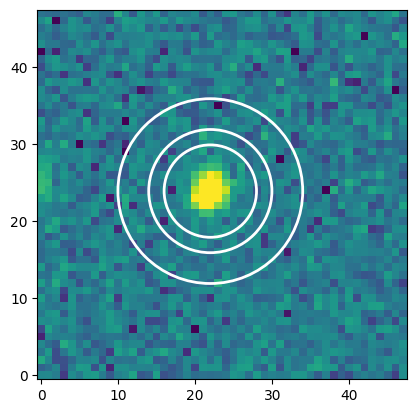

{'mjd': 52191.3094444, 'exptime': 180.0, 'magnitude': -10.910521215543644, 'sky': -9.513962523087848}
29
Filename: data/9_Oct/td10r_n3_0143.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      99   (2048, 2063)   float32   
data shape :  (2063, 2048)
mjd :  52191.3216204
exposition :  180.0  secs
resultats centroid =24.209 ,22.040
 id      xcenter            ycenter       aperture_sum
           pix                pix                     
--- ------------------ ------------------ ------------
  1 24.209212954520694 22.040075932860457    261787.86

Sum_target_raw=261787.864

 id      xcenter            ycenter       aperture_sum
           pix                pix                     
--- ------------------ ------------------ ------------
  1 24.209212954520694 22.040075932860457    533001.37

Sky_background=533001.371

Target flux without sky=21937.247

instrumental magnitude=-10.853

533001.3710738097


/tmp/ipykernel_432921/2393849239.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_432921/2393849239.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_432921/2393849239.py:81: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_432921/239384

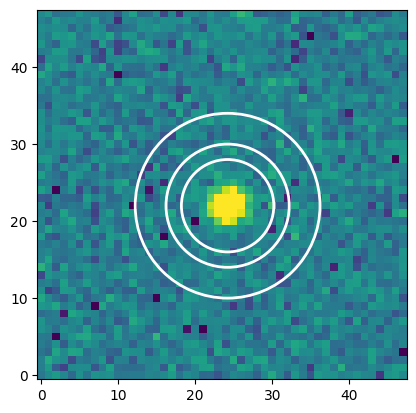

{'mjd': 52191.3216204, 'exptime': 180.0, 'magnitude': -10.852955295065351, 'sky': -9.559095847999442}
30
Filename: data/9_Oct/td10r_n3_0145.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      99   (2048, 2063)   float32   
data shape :  (2063, 2048)
mjd :  52191.3284144
exposition :  180.0  secs
resultats centroid =23.635 ,22.828
 id      xcenter            ycenter      aperture_sum
           pix                pix                    
--- ------------------ ----------------- ------------
  1 23.634685149172697 22.82849563231961    269796.02

Sum_target_raw=269796.024

 id      xcenter            ycenter      aperture_sum
           pix                pix                    
--- ------------------ ----------------- ------------
  1 23.634685149172697 22.82849563231961    553633.01

Sky_background=553633.011

Target flux without sky=20661.169

instrumental magnitude=-10.788

553633.0114845021


/tmp/ipykernel_432921/2393849239.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_432921/2393849239.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_432921/2393849239.py:81: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_432921/239384

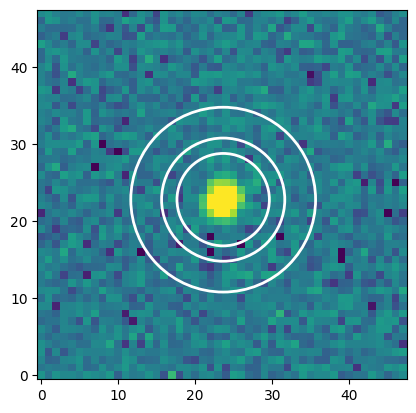

{'mjd': 52191.3284144, 'exptime': 180.0, 'magnitude': -10.787887223588717, 'sky': -9.60032997728226}
31
Filename: data/9_Oct/td10r_n3_0147.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      99   (2048, 2063)   float32   
data shape :  (2063, 2048)
mjd :  52191.3356944
exposition :  180.0  secs
resultats centroid =23.947 ,22.931
 id      xcenter           ycenter      aperture_sum
           pix               pix                    
--- ----------------- ----------------- ------------
  1 23.94749362322191 22.93139712131652    280621.03

Sum_target_raw=280621.034

 id      xcenter           ycenter      aperture_sum
           pix               pix                    
--- ----------------- ----------------- ------------
  1 23.94749362322191 22.93139712131652    577180.75

Sky_background=577180.747

Target flux without sky=20889.698

instrumental magnitude=-10.800

577180.7472093878


/tmp/ipykernel_432921/2393849239.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_432921/2393849239.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_432921/2393849239.py:81: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_432921/239384

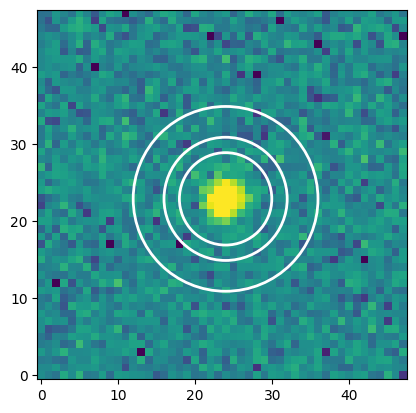

{'mjd': 52191.3356944, 'exptime': 180.0, 'magnitude': -10.799830410132289, 'sky': -9.645554622703305}
32
Filename: data/9_Oct/td10r_n3_0149.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      99   (2048, 2063)   float32   
data shape :  (2063, 2048)
mjd :  52191.3423843
exposition :  180.0  secs
resultats centroid =23.129 ,23.810
 id      xcenter           ycenter      aperture_sum
           pix               pix                    
--- ----------------- ----------------- ------------
  1 23.12854952630784 23.81045428662494    291104.43

Sum_target_raw=291104.432

 id      xcenter           ycenter      aperture_sum
           pix               pix                    
--- ----------------- ----------------- ------------
  1 23.12854952630784 23.81045428662494    602374.67

Sky_background=602374.665

Target flux without sky=20035.833

instrumental magnitude=-10.755

602374.6650712944


/tmp/ipykernel_432921/2393849239.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSum_target_raw=%.3f\n'%(Sum_target_raw))
/tmp/ipykernel_432921/2393849239.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('\nSky_background=%.3f\n'%(Sky_background))
/tmp/ipykernel_432921/2393849239.py:81: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if debug: print('Target flux without sky=%.3f\n'%(Sum_target))
/tmp/ipykernel_432921/239384

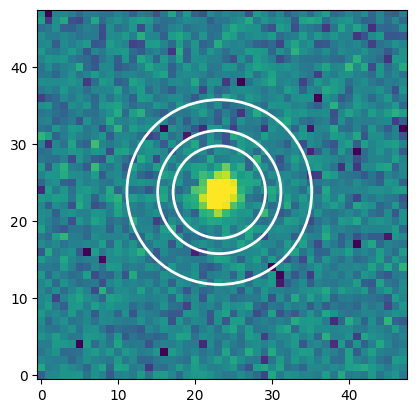

{'mjd': 52191.3423843, 'exptime': 180.0, 'magnitude': -10.754518502469443, 'sky': -9.691941777109015}


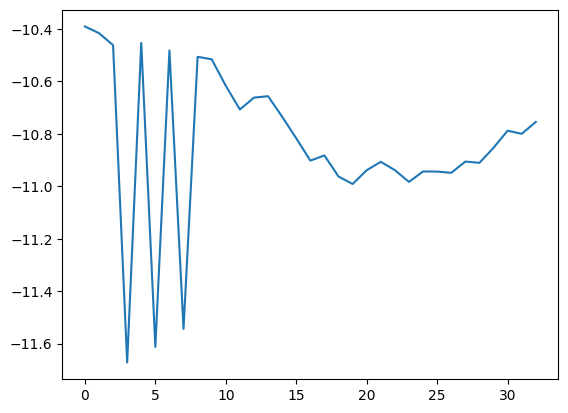

In [23]:

# start = (1513, 863)
# end   = (2055, 640)

# start = (1513, 863)
# end   = (1841, 724)

# Debug with star
# start = (1685, 1091)
# end = (1700-13, 968+122)

start = (1172, 1166)
end = (1301-13, 993+122)

sample_positions = len(files)



r=6        # radius for measuring target flux
r_in=8     # inner radius for the annulus used for measuring sky background
r_out=12    # outer radius for the annulus used for measuring sky background 



# The positions here consider all images aligned.
interpolated = np.round(PositionInterpolation(start, end, sample_positions))
# Let's use the given thingy to get the mag

dic = []
for i, f in enumerate(files):
    print(i)
    Xcent = int(interpolated[i][0] + absolute_offsets[i][0])
    Ycent = int(interpolated[i][1] + absolute_offsets[i][1])


    foo = GivenFileThingy(f, r, r_in, r_out, Xcent, Ycent, 24, debug=True)
    #                                                                  ^ leave to true or buggy

    print(foo)
    dic.append(foo)

# print(len(dic))
# print([ i for i in range(len(dic))], [i["magnitude"] for i in dic])
plt.show()

plt.plot([i for i in range(len(dic))], [i["magnitude"] for i in dic])
plt.show()


### Getting rid of misshaps in tracking (instead of tracking manually...)

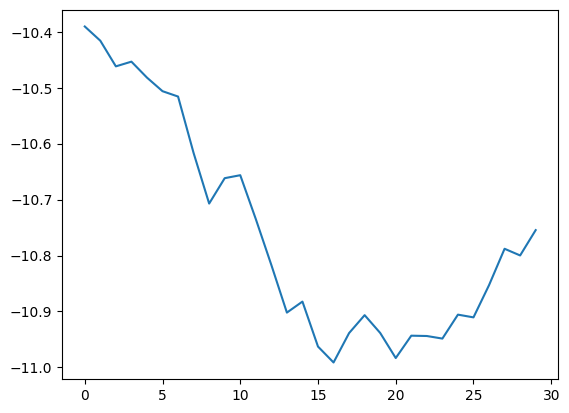

In [24]:
dic = [dic[i] for i in range(len(dic)) if i not in [3, 5, 7]]

plt.plot([i for i in range(len(dic))], [i["magnitude"] for i in dic])
plt.show()

## Coordinates determination using Plate Solving on astrometry.net

The plate solving results are available [here](https://nova.astrometry.net/user_images/11356787#annotated). 

```
Center (RA, Dec):	(18.375, 6.033)
Center (RA, hms):	01h 13m 30.118s
Center (Dec, dms):	+06° 01' 57.956"
Size:	13.5 x 13.6 arcmin
Radius:	0.160 deg
Pixel scale:	0.395 arcsec/pixel
```

SIMBAD request on the coordinates using ALADIN gives the following :

![simbad 8](./rsc/ALADIN_9.png)

2MASS operates in the IR bands. 

Selected star is [2MASS J01132281+0607541](https://vizier.cds.unistra.fr/viz-bin/VizieR-S?2MASS%20J01132281%2b0607541) with the 

Searching on VIZIER for stars on that position yields only one result, with $R_{mag} = 13.1$ Note that it is the same star used in night 8.


Image is not overexposed so we're not clipping => we're good

1835397.5168175509


/tmp/ipykernel_432921/2393849239.py:82: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Magnitude=-2.5*log10(Sum_target)
/tmp/ipykernel_432921/2393849239.py:86: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Sky_magnitude = -2.5 * log10(Sky_flux)


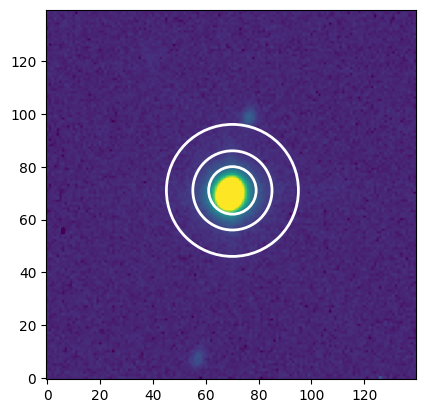

Mag_obs : -16.605007687546408	 2MASS : 13.1	 Offset : 29.705007687546406


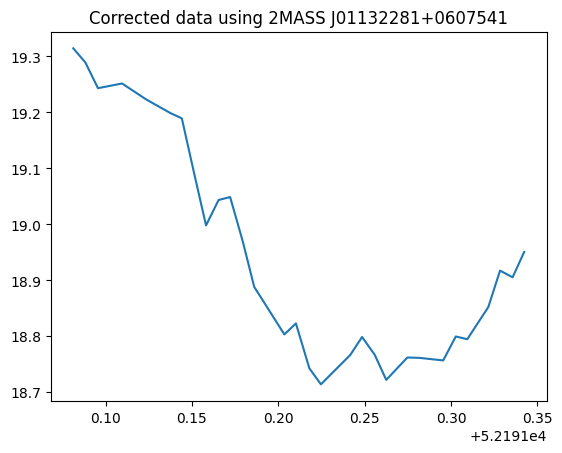

In [25]:
Ref_star = (1287, 1936)
mag_obs = GivenFileThingy(files[0], 9, 15, 25, Ref_star[0], Ref_star[1], 70)["magnitude"]
plt.show() # why is it always displaying something
mag_2MASS = 13.1

mag_offset = mag_2MASS-mag_obs

print(f'Mag_obs : {mag_obs}\t 2MASS : {mag_2MASS}\t Offset : {mag_offset}')

# corrected data
corrected_data = [i["magnitude"]+mag_offset for i in dic]
plt.plot([i["mjd"] for i in dic], corrected_data)
plt.title("Corrected data using 2MASS J01132281+0607541")
plt.show()


# create a new dic with corrected data : 
for i in range(len(dic)):
    dic[i]["magnitude"]+=mag_offset




# Rotation period computation

We consider the magnitude of the object to vary in a sinusoidal fashion.

fitting to a sinusoid for the first night

52191.0812616
Fitted parameters: omega = 0.3715289676112343, phi = 1.673681990520384, offset = 19.01390440301829, amplitude = 0.28815727292993454


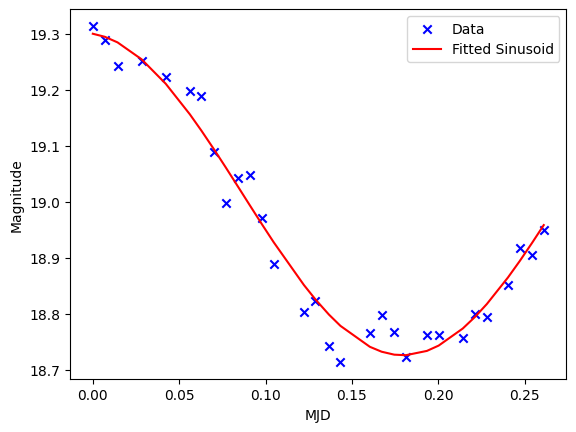

Mean magnitude : 	19.01390440301829
Magnitude variation : 	0.5763145458598691
Period : 		0.3715289676112343 


In [26]:

import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the sinusoidal function to fit
def sinusoid(x, amp, a, b, c):
    return amp * np.sin((2 * np.pi / a) * x + b) + c

# MJD offset
mjd_offset=dic[0]["mjd"]
print(mjd_offset)


# Example data (assuming dic is a dictionary with 'mjd' and 'magnitude' entries)
x = np.array([dic[i]["mjd"]-mjd_offset for i in range(len(dic))])
y = np.array([dic[i]["magnitude"] for i in range(len(dic))])

# Approximate values based on your observations
approx_a = 0.32  # frequency to achieve period of about 60
approx_b = 0               # phase offset (adjust if you have an estimate)
approx_c = 17              # vertical offset around 17
approx_amp = 1              # vertical offset around 17

# Initial guess for parameters
initial_guess = [approx_amp, approx_a, approx_b, approx_c]

# Perform the curve fitting
params, covariance = curve_fit(sinusoid, x, y, p0=initial_guess)

# Extract the optimal parameters
amp_opt, a_opt, b_opt, c_opt = params
print(f"Fitted parameters: omega = {a_opt}, phi = {b_opt}, offset = {c_opt}, amplitude = {amp_opt}")

# Calculate the fitted sinusoid for plotting
y_fit = sinusoid(x, amp_opt, a_opt, b_opt, c_opt)

# Plot the data and the fitted curve
plt.scatter(x, y, label='Data', color='blue', marker="x")
plt.plot(x, y_fit, label='Fitted Sinusoid', color='red')
plt.xlabel('MJD')
plt.ylabel('Magnitude')
plt.legend()
plt.show()

print(f'Mean magnitude : \t{c_opt}\nMagnitude variation : \t{amp_opt*2}\nPeriod : \t\t{a_opt} ')

In [27]:
def mjd_to_hours(mjd):
    return mjd * 24

mjd_to_hours(a_opt)

8.916695222669622

# Dump data to ascii file

In [28]:
import csv

# Specify the output ASCII file path
output_file = "9_oct.txt"

# Write each dictionary to a new line in the file with each column as a key
with open(output_file, "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=dic[0].keys(), delimiter='\t')
    writer.writeheader()
    writer.writerows(dic)